In [2]:
#| label: import-libraries
# ============================================================
# Imports & global settings
# ------------------------------------------------------------
# This notebook implements the second pipeline: generating data
# for multi-objective benchmark functions (ZDT/DTLZ), building
# surrogate models, and visualizing/inspecting results with the
# spotdesirability + spotoptim toolchain.
#
# Notes:
# - NumPy/Pandas: core numerical + tabular handling.
# - scikit-learn: surrogate models (e.g., Random Forest, GP) and
#   evaluation utilities.
# - Matplotlib/Seaborn: plots (2D/3D).
# - SciPy: sampling (LHS) and optimization utilities.
# - spotdesirability: desirability functions (DMin/DMax/DOverall).
# - spotoptim: Pareto utilities, exploratory plots, and multi-objective helpers.
# ============================================================

import copy
import numpy as np
import pandas as pd
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from scipy.stats.qmc import LatinHypercube
from scipy.optimize import dual_annealing

from spotdesirability.utils.desirability import DMin, DMax, DOverall

from spotoptim.inspection.predictions import plot_actual_vs_predicted
from spotoptim.inspection import (
    generate_mdi,
    generate_imp,
    plot_importances,
    plot_feature_importances,
    plot_feature_scatter_matrix
)

from spotoptim.utils.boundaries import get_boundaries, map_to_original_scale
from spotoptim.mo.pareto import is_pareto_efficient, plot_mo
from spotoptim.eda import plot_ip_boxplots, plot_ip_histograms
from spotoptim.utils import get_combinations
from spotoptim.sampling.lhs import rlh

from spotoptim.function.mo import mo_conv2_max
from spotoptim.mo.pareto import (mo_xy_surface, mo_xy_contour, mo_pareto_optx_plot)
from spotoptim.utils.eval import mo_cv_models, mo_eval_models


# Suppress warnings to keep notebook output clean.
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# Reproducibility / model defaults (used throughout the notebook)
# ------------------------------------------------------------
n_estimators = 100
max_depth = None
random_state = 42

In [3]:
# ============================================================
# Benchmark function implementations
# ------------------------------------------------------------
# Local implementations of ZDT1–ZDT6 and DTLZ2 test functions.
# Each function accepts either a single decision vector (1D array)
# or a batch of vectors (2D array) as input.
# ============================================================

import numpy as np


# -------------------------------------------------------
# Internal helpers
# -------------------------------------------------------

def _as_2d(x: np.ndarray) -> tuple:
    """Convert input to 2D array. Returns (X2d, was_1d)."""
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        return x.reshape(1, -1), True
    if x.ndim == 2:
        return x, False
    raise ValueError(f"Input must be 1D or 2D array, got shape {x.shape}")

def _infer_n(X: np.ndarray, n_obj: int) -> int:
    """Infer number of decision variables from input array."""
    return X.shape[1]

def _check_dims(X: np.ndarray, n_obj: int, n: int) -> None:
    """Validate that input has at least n_obj decision variables."""
    if X.shape[1] < n_obj:
        raise ValueError(
            f"Input must have at least {n_obj} decision variables, got {X.shape[1]}"
        )

def _require_min_dim(X: np.ndarray, n_min: int = 2) -> None:
    """Ensure at least n_min decision variables are provided."""
    if X.shape[1] < n_min:
        raise IndexError(
            f"Input must have at least {n_min} decision variables, got {X.shape[1]}"
        )


# -------------------------------------------------------
# ZDT functions
# -------------------------------------------------------

def zdt1(x: np.ndarray) -> np.ndarray:
    """ZDT1 (convex Pareto front). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 9.0 * np.sum(X[:, 1:], axis=1) / (n - 1)
    f2 = g * (1.0 - np.sqrt(f1 / g))
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt2(x: np.ndarray) -> np.ndarray:
    """ZDT2 (non-convex Pareto front). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 9.0 * np.sum(X[:, 1:], axis=1) / (n - 1)
    f2 = g * (1.0 - (f1 / g) ** 2)
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt3(x: np.ndarray) -> np.ndarray:
    """ZDT3 (disconnected Pareto front). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 9.0 * np.sum(X[:, 1:], axis=1) / (n - 1)
    f2 = g * (1.0 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10.0 * np.pi * f1))
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt4(x: np.ndarray) -> np.ndarray:
    """ZDT4 (multimodal, convex PF). Domain: x ∈ [0,1]×[-5,5]^(n-1), n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = X[:, 0]
    n = X.shape[1]
    g = 1.0 + 10.0 * (n - 1) + np.sum(
        X[:, 1:] ** 2 - 10.0 * np.cos(4.0 * np.pi * X[:, 1:]), axis=1
    )
    f2 = g * (1.0 - np.sqrt(f1 / g))
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F

def zdt6(x: np.ndarray) -> np.ndarray:
    """ZDT6 (non-uniform density, concave PF). Domain: x ∈ [0,1]^n with n≥2."""
    X, was_1d = _as_2d(x)
    _require_min_dim(X, 2)
    f1 = 1.0 - np.exp(-4.0 * X[:, 0]) * (np.sin(6.0 * np.pi * X[:, 0])) ** 6
    n = X.shape[1]
    g = 1.0 + 9.0 * ((np.sum(X[:, 1:], axis=1) / (n - 1)) ** 0.25)
    f2 = g * (1.0 - (f1 / g) ** 2)
    F = np.column_stack([f1, f2])
    return F[0] if was_1d else F



print("✓ ZDT1, ZDT2, ZDT3, ZDT4, ZDT6, loaded from local implementations.")


✓ ZDT1, ZDT2, ZDT3, ZDT4, ZDT6, loaded from local implementations.


In [4]:
# ============================================================
# Common utilities
# ------------------------------------------------------------
# This cell defines reusable helpers for the whole notebook:
#
# Step 1 (data only)
#   - Evaluate analytic ZDT/DTLZ functions on a 2D decision-space grid
#   - Build desirability functions (per objective + overall) from samples
#   - Compute overall desirability values on the grid
#
# Step 2 (plots only)
#   - Surface/contour plots for objective landscapes over a 2D slice
#   - Pareto plots in objective space and input space
#   - Individual + overall desirability visualizations
#
# Important:
# - Many benchmark functions have more than 2 decision variables; here we
#   visualize a 2D slice (pair=(i,j)) while fixing all other variables to
#   `fixed_value` (default: 0.0). This is for visualization/inspection only.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import Normalize

from spotdesirability.utils.desirability import DMin, DMax, DOverall
from spotoptim.mo.pareto import plot_mo, mo_pareto_optx_plot

np.random.seed(42)

# -----------------------------
# STEP 1 HELPERS (DATA ONLY)
# -----------------------------

def eval_func_on_grid_data(test_func, n_var, pair=(0, 1), bounds=((0, 1), (0, 1)),
                           n_grid=80, fixed_value=0.0, func_kwargs=None):
    """
    Evaluate an analytic benchmark function on a 2D decision-space grid.

    Parameters
    ----------
    test_func : callable
        Vectorized function that maps X (n_points x n_var) -> Y (n_points x n_obj).
    n_var : int
        Total number of decision variables.
    pair : tuple(int, int)
        Indices of the two decision variables used for the 2D slice.
    bounds : ((float,float),(float,float))
        Bounds for the selected variable pair.
    n_grid : int
        Grid resolution per axis (n_grid x n_grid evaluations).
    fixed_value : float
        Value assigned to all non-selected variables (the "slice" setting).
    func_kwargs : dict or None
        Optional keyword arguments forwarded to `test_func`.

    Returns
    -------
    Xi, Yi : 2D arrays
        Meshgrid coordinates for the selected variable pair.
    Ygrid : ndarray
        Objective values on the grid with shape (n_obj, n_grid, n_grid).
    """
    if func_kwargs is None:
        func_kwargs = {}

    (xmin, xmax), (ymin, ymax) = bounds
    i, j = pair

    xi = np.linspace(xmin, xmax, n_grid)
    yi = np.linspace(ymin, ymax, n_grid)
    Xi, Yi = np.meshgrid(xi, yi)

    # Build full decision vectors by varying only the selected pair.
    X = np.full((n_grid * n_grid, n_var), fixed_value, dtype=float)
    X[:, i] = Xi.ravel()
    X[:, j] = Yi.ravel()

    Y = test_func(X, **func_kwargs)  # (n_grid*n_grid, n_obj)
    n_obj = Y.shape[1]

    Ygrid = np.zeros((n_obj, n_grid, n_grid), dtype=float)
    for k in range(n_obj):
        Ygrid[k] = Y[:, k].reshape(n_grid, n_grid)

    return Xi, Yi, Ygrid


def make_grid_dataset(test_func, n_var, pairs=[(0, 1)], bounds=((0, 1), (0, 1)),
                      n_grid=80, fixed_value=0.0, func_kwargs=None):
    """
    Evaluate the function on one or multiple 2D slices (variable pairs).

    Returns
    -------
    grid_data : dict
        grid_data[(i,j)] = {"Xi": Xi, "Yi": Yi, "Ygrid": Ygrid}
    """
    grid_data = {}
    for pair in pairs:
        Xi, Yi, Ygrid = eval_func_on_grid_data(
            test_func=test_func,
            n_var=n_var,
            pair=pair,
            bounds=bounds,
            n_grid=n_grid,
            fixed_value=fixed_value,
            func_kwargs=func_kwargs
        )
        grid_data[tuple(pair)] = {"Xi": Xi, "Yi": Yi, "Ygrid": Ygrid}
    return grid_data


def make_desirability_objects_from_samples(y_samples, is_minimization=True, scale=None):
    """
    Create per-objective desirability functions from observed sample ranges.

    The min/max of each objective in `y_samples` is used as (low, high) for
    DMin (for minimization) or DMax (for maximization). The individual
    desirabilities are then aggregated via DOverall.
    """
    d_funcs = []
    for i in range(y_samples.shape[1]):
        low, high = np.min(y_samples[:, i]), np.max(y_samples[:, i])
        if is_minimization:
            d = DMin(low=low, high=high) if scale is None else DMin(low=low, high=high, scale=scale)
        else:
            d = DMax(low=low, high=high) if scale is None else DMax(low=low, high=high, scale=scale)
        d_funcs.append(d)

    D_overall = DOverall(*d_funcs)
    return d_funcs, D_overall


def make_overall_desirability_grid(grid_data, D_overall):
    """
    Compute overall desirability values on each precomputed objective grid.

    Returns
    -------
    Dmaps : dict
        Dmaps[(i,j)] = Dgrid (n_grid x n_grid)
    """
    Dmaps = {}
    for pair, data in grid_data.items():
        Ygrid = data["Ygrid"]
        n_obj, n_grid, _ = Ygrid.shape

        # Flatten objectives -> compute desirability -> reshape back to grid.
        Yflat = np.column_stack([Ygrid[k].ravel() for k in range(n_obj)])
        Dflat = D_overall.predict(Yflat).reshape(n_grid, n_grid)
        Dmaps[pair] = Dflat
    return Dmaps


# -----------------------------
# STEP 2 PLOTTERS (PLOTS ONLY)
# -----------------------------

def plot_surface_from_grid(grid_data, target_names=("f1", "f2")):
    """
    Plot 3D objective surfaces for each objective in `grid_data`.

    Surfaces are shown over the selected 2D decision-variable slice.
    """
    for pair, data in grid_data.items():
        i, j = pair
        Xi, Yi, Ygrid = data["Xi"], data["Yi"], data["Ygrid"]

        fig = plt.figure(figsize=(12, 5))
        for k in range(Ygrid.shape[0]):
            ax = fig.add_subplot(1, Ygrid.shape[0], k + 1, projection="3d")

            Z = Ygrid[k]
            norm = Normalize(vmin=np.nanmin(Z), vmax=np.nanmax(Z))
            facecolors = cm.viridis(norm(Z))

            ax.plot_surface(
                Xi, Yi, Z,
                facecolors=facecolors,
                rstride=1, cstride=1,
                linewidth=0,
                antialiased=True,
                shade=False
            )

            mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
            mappable.set_array(Z)
            fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.08)

            ax.set_title(target_names[k])
            ax.set_xlabel(f"x{i+1}")
            ax.set_ylabel(f"x{j+1}")

        plt.tight_layout()
        plt.show()


def plot_contour_from_grid(grid_data, target_names=("f1", "f2")):
    """
    Plot 2D filled contours of each objective over the selected 2D slice.
    """
    for pair, data in grid_data.items():
        i, j = pair
        Xi, Yi, Ygrid = data["Xi"], data["Yi"], data["Ygrid"]

        fig, axes = plt.subplots(1, Ygrid.shape[0], figsize=(12, 5))
        if Ygrid.shape[0] == 1:
            axes = [axes]

        for k, ax in enumerate(axes):
            cs = ax.contourf(Xi, Yi, Ygrid[k], levels=25)
            ax.set_title(target_names[k])
            ax.set_xlabel(f"x{i+1}")
            ax.set_ylabel(f"x{j+1}")
            fig.colorbar(cs, ax=ax)

        plt.tight_layout()
        plt.show()


def plot_pareto_from_y(y_samples, func_name="PROBLEM", target_names=("f1", "f2"), is_minimization=True):
    """
    Plot objective-space scatter and (if available) the analytic Pareto front.

    This uses only objective samples `y_samples` (no surrogate model).
    """
    pareto_type = "min" if is_minimization else "max"
    plot_mo(
        y_orig=y_samples,
        target_names=list(target_names),
        combinations=[(0, 1)],
        pareto=pareto_type,
        pareto_front_orig=True,
        title=f"{func_name} - Pareto front ({pareto_type}imization)",
        pareto_label=True
    )
    plt.show()


def plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=True,
    var_names=("x1", "x2"),
    target_names=("f1", "f2"),
):
    """
    Plot Pareto-optimal points in the 2D decision-variable space.

    `X_2d` must contain exactly two columns corresponding to `var_names`.
    Points are colored by objective values.
    """
    import matplotlib.pyplot as plt

    # Temporarily suppress plt.show() inside the library plotter,
    # then restore it so the final figure is displayed correctly.
    _old_show = plt.show
    plt.show = lambda *args, **kwargs: None

    try:
        mo_pareto_optx_plot(X=X_2d, Y=y_samples, minimize=is_minimization)

        fig = plt.gcf()
        axes = fig.axes

        if len(axes) >= 2:
            for ax in axes[:2]:
                ax.set_xlabel(var_names[0])
                ax.set_ylabel(var_names[1])

            axes[0].set_title(f"{target_names[0]} (Color)")
            axes[1].set_title(f"{target_names[1]} (Color)")

        if len(axes) >= 4:
            axes[-2].set_ylabel(target_names[0])
            axes[-1].set_ylabel(target_names[1])

        plt.tight_layout()

    finally:
        plt.show = _old_show

    plt.show()


def plot_individual_desirability(d_funcs, target_names=("f1", "f2")):
    """
    Plot each per-objective desirability function.
    """
    for k, d in enumerate(d_funcs):
        d.plot(xlabel=target_names[k], figsize=(6, 4))


def plot_overall_desirability_from_grid(grid_data, Dmaps):
    """
    Plot overall desirability as a contour map over the selected 2D slice.
    """
    for pair, data in grid_data.items():
        i, j = pair
        Xi, Yi = data["Xi"], data["Yi"]
        Dgrid = Dmaps[pair]

        plt.figure(figsize=(6, 5))
        cs = plt.contourf(Xi, Yi, Dgrid, levels=25)
        plt.title("Overall desirability")
        plt.xlabel(f"x{i+1}")
        plt.ylabel(f"x{j+1}")
        plt.colorbar(cs)
        plt.tight_layout()
        plt.show()


def plot_pareto_scatter_only(y_samples, func_name="PROBLEM", target_names=("f1", "f2"), is_minimization=True):
    """
    Plot only the objective-space scatter of points (no analytic Pareto front).
    """
    pareto_type = "min" if is_minimization else "max"
    plot_mo(
        y_orig=y_samples,
        target_names=list(target_names),
        combinations=[(0, 1)],
        pareto=pareto_type,
        pareto_front_orig=False,
        title=f"{func_name} - Pareto front ({pareto_type}imization)",
        pareto_label=True
    )
    plt.show()


In [5]:
# ============================================================
# ZDT1 — Step 1: Data generation
# ------------------------------------------------------------
# This cell prepares *all analytic data* needed for later steps:
#   (A) Sample points on a 2D decision-variable slice (X_2d) and embed
#       them into the full decision space (X_full), then evaluate the
#       analytic benchmark function to obtain objective samples (y_samples).
#   (B) Evaluate the analytic function on a dense 2D grid for the selected
#       variable pairs (grid_data) to support surface/contour plots.
#   (C) Build per-objective desirability functions + overall desirability
#       from the sample ranges, then compute overall desirability on the grid.
#
# Notes:
# - The 2D slice is defined by `pair_opt` (e.g., (0,1)). All other variables
#   are fixed to `fixed_value` (default: 0.0).
# ============================================================

func_name = "ZDT1"
test_func = zdt1

n_var = 30
pairs = [(0, 1)]               # decision-variable pairs used for slice visualizations
pair_opt = pairs[0]
n_grid = 70
fixed_value = 0.0
bounds = ((0, 1), (0, 1))      # bounds for the two variables of the selected slice
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = None             # optional keyword arguments for the test function (if required)

def make_slice_samples_generic(n_nonopt=600, n_pareto=300, n_var=30, fixed_value=0.0, pair=(0, 1)):
    """
    Generate sample points on a 2D decision-variable slice and embed into full space.

    Sampling strategy
    -----------------
    1) Random "non-optimal" points:
       - Two slice variables sampled uniformly in [0,1]^2.
    2) Simple reference line (ZDT1-style demonstration):
       - Vary the first slice variable in [0,1] while fixing the second to 0.

    Returns
    -------
    X_2d : ndarray (n_points, 2)
        Points in the 2D slice.
    X_full : ndarray (n_points, n_var)
        Full-dimensional decision vectors with non-slice variables fixed.
    """
    X_nonopt_2d = np.random.rand(n_nonopt, 2)
    x0_range = np.linspace(0, 1, n_pareto)
    X_ref_2d = np.column_stack([x0_range, np.zeros(n_pareto)])

    X_2d = np.vstack([X_nonopt_2d, X_ref_2d])

    X_full = np.full((X_2d.shape[0], n_var), fixed_value, dtype=float)
    i, j = tuple(pair)
    X_full[:, i] = X_2d[:, 0]
    X_full[:, j] = X_2d[:, 1]
    return X_2d, X_full


print(f"\n{'='*60}")
print(f"DATA GENERATION FOR {func_name}")
print(f"{'='*60}")

# Step 1A: sample points (X) and evaluate objectives (Y) analytically
X_2d, X_full = make_slice_samples_generic(
    n_nonopt=600, n_pareto=300, n_var=n_var, fixed_value=fixed_value, pair=pair_opt
)
y_samples = test_func(X_full) if func_kwargs is None else test_func(X_full, **func_kwargs)

print("X_2d shape   :", X_2d.shape)
print("X_full shape :", X_full.shape)
print("y shape      :", y_samples.shape)

# Step 1B: evaluate the analytic function on a dense grid for each chosen pair
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

# Step 1C: build desirability functions from sample ranges and map them on the grid
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"{func_name} STEP 1 DONE")



DATA GENERATION FOR ZDT1
X_2d shape   : (900, 2)
X_full shape : (900, 30)
y shape      : (900, 2)
ZDT1 STEP 1 DONE



VISUALIZATION FOR ZDT1


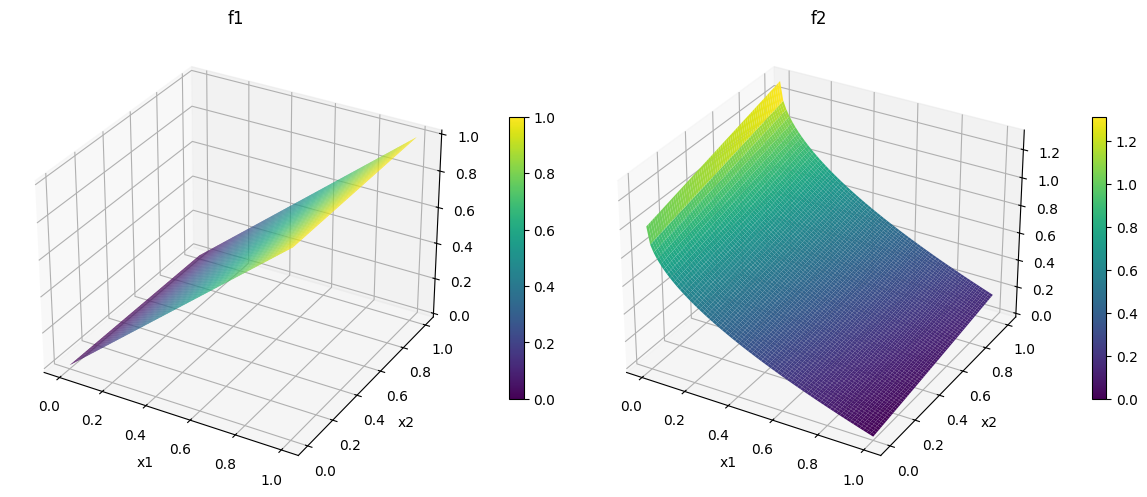

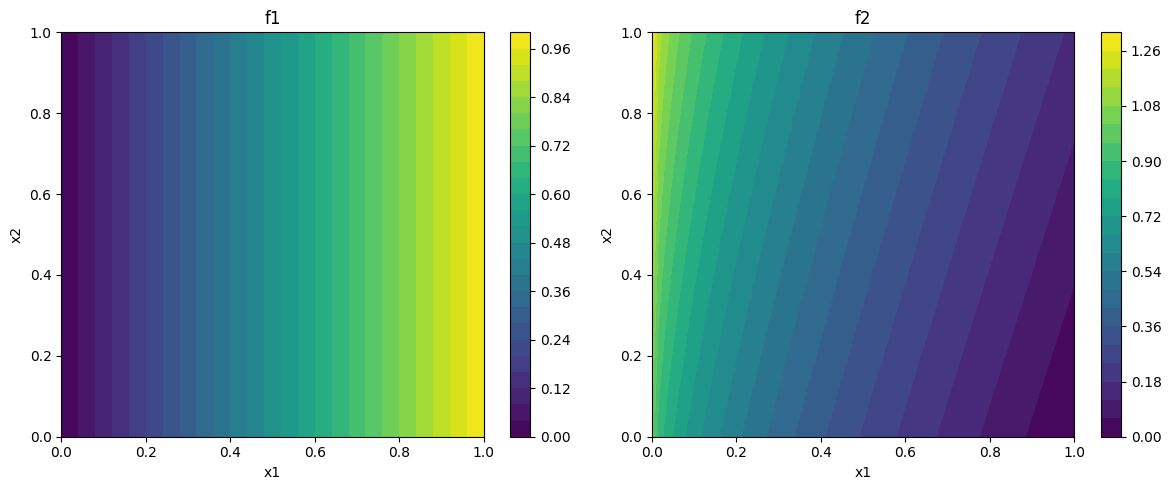

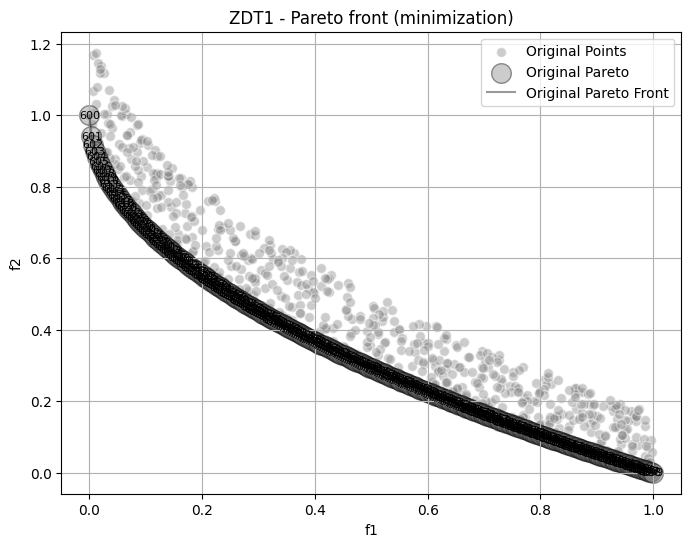

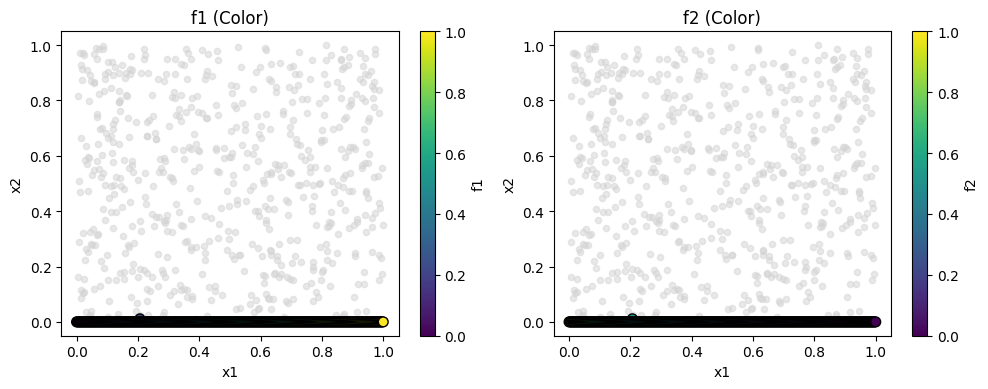

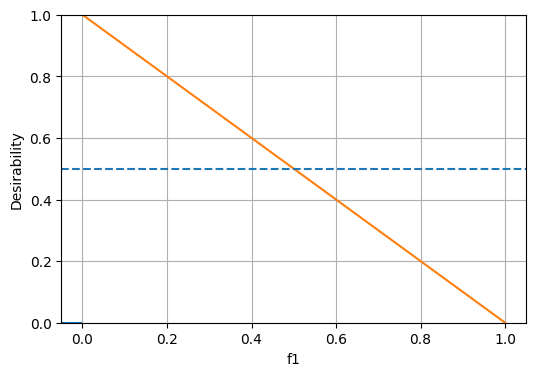

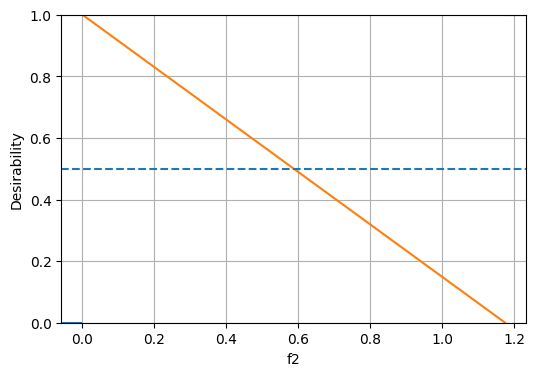

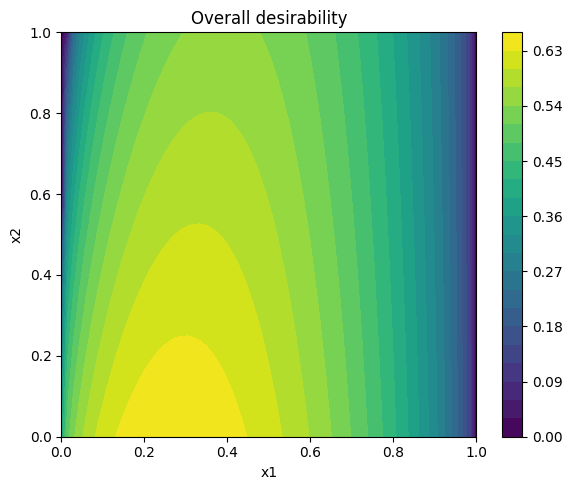

ZDT1 STEP 2 DONE


In [6]:
# ============================================================
# ZDT1 — Step 2: Visualization
# ------------------------------------------------------------
# This cell produces all visual outputs for the currently selected problem
# using *only* the analytic data computed in Step 1.
#
# Expected inputs from Step 1:
#   - X_2d      : sampled points in the 2D decision-variable slice
#   - y_samples : analytic objective values for X_full (corresponding to X_2d)
#   - grid_data : analytic objective grids for surface/contour plots
#   - d_funcs   : per-objective desirability functions
#   - Dmaps     : overall desirability values on each grid
#
# Plots generated:
#   1) Objective surfaces (3D) over the 2D slice
#   2) Objective contour maps (2D) over the 2D slice
#   3) Objective-space Pareto scatter + (if available) analytic Pareto front
#   4) Input-space view of Pareto-optimal points in the 2D slice
#   5) Per-objective desirability curves
#   6) Overall desirability contour map over the 2D slice
# ============================================================

print(f"\n{'='*60}")
print(f"VISUALIZATION FOR {func_name}")
print(f"{'='*60}")

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)
plot_pareto_from_y(y_samples, func_name=func_name, target_names=target_names, is_minimization=is_minimization)
plot_pareto_x_in_input_space(X_2d, y_samples, is_minimization=is_minimization)
plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")


ZDT2: Non-Convex Pareto Front
------------------------------------------------------------
Non-optimal samples (2D slice): 500
Pareto samples (true PF, x2=0): 200
Total samples used for plots: 700
Objective space shape: (700, 2)
f1 range: [0.0000, 1.0000]
f2 range: [0.0000, 1.3062]
ZDT2 STEP 1 DONE
grid_data keys: [(0, 1)]


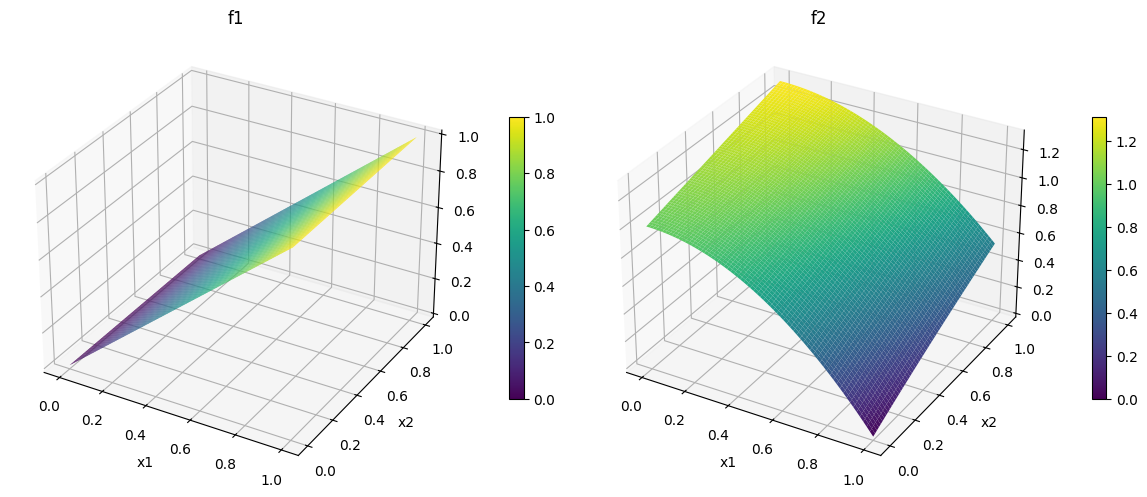

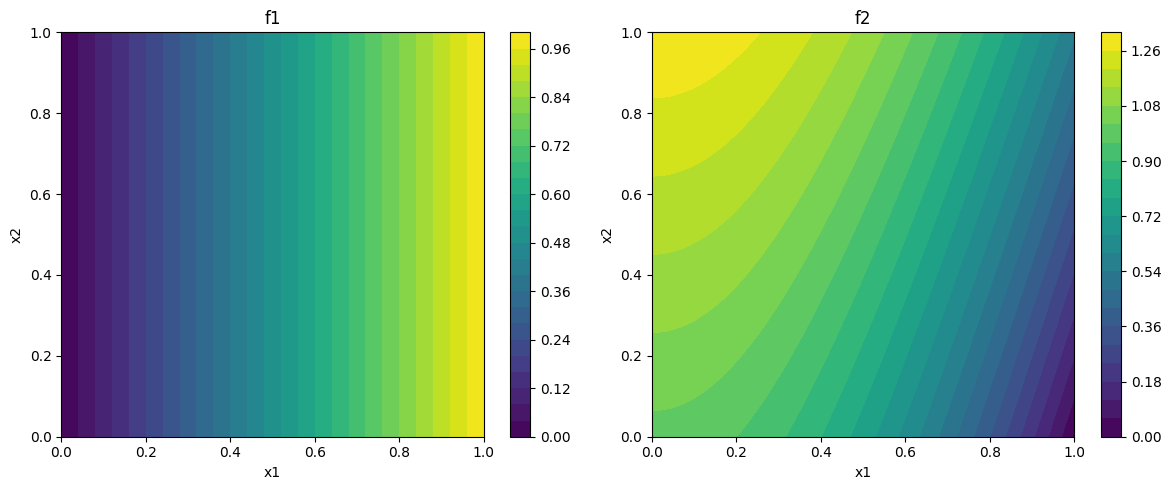

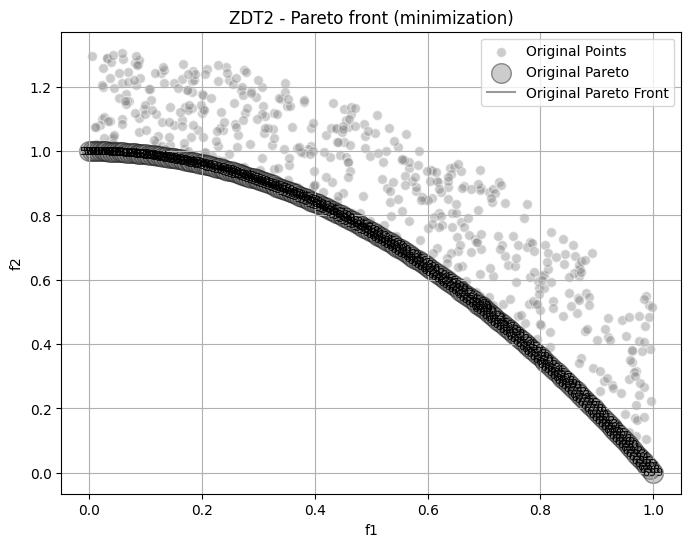

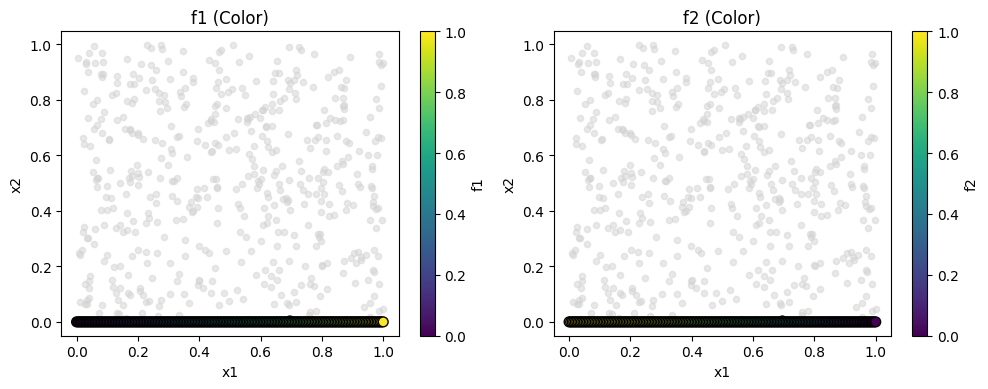

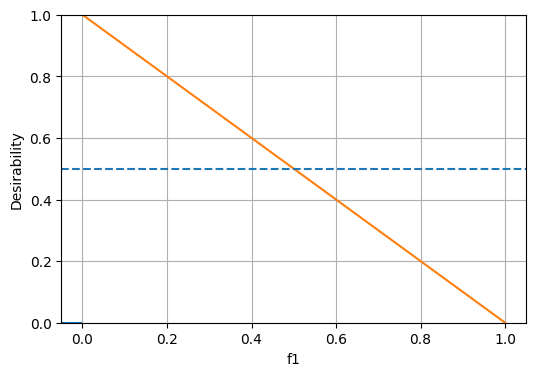

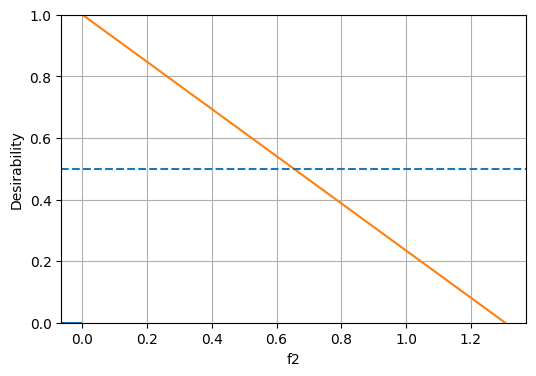

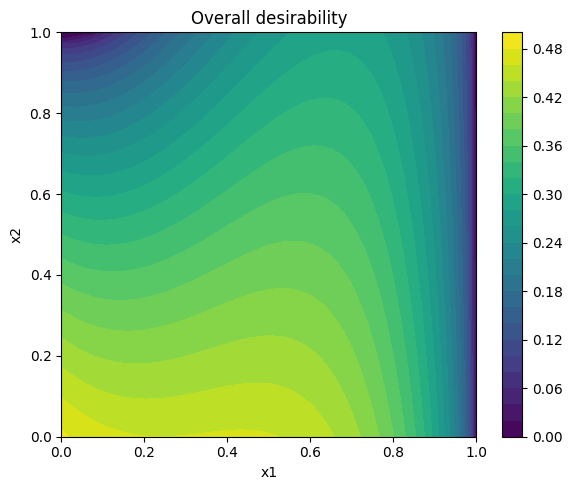

ZDT2 STEP 2 DONE


In [7]:
# ============================================================
# ZDT2 — Step 1: Data generation
# ============================================================


print("ZDT2: Non-Convex Pareto Front")
print("-" * 60)

# -------------------------
# Sampling
# -------------------------
n_nonopt = 500      # Number of non-optimal samples on the 2D slice (x1, x2)
n_pareto = 200      # Number of true Pareto samples

# 1) Non-optimal (2D slice)
X_nonopt_2d = np.random.rand(n_nonopt, 2)   # x1, x2 ~ U(0, 1)

# 2) TRUE Pareto points
#    For ZDT2: Pareto-optimal when x2..x(n-1) = 0, only x1 varies.
#    In the 2D slice: x2 = 0 and x1 spans [0, 1]
x0_range = np.linspace(0, 1, n_pareto)
X_pareto_2d = np.column_stack([x0_range, np.zeros(n_pareto)])  # (x1, x2=0)

# 3) Combine both (so plots remain consistent)
X_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
n_samples = X_2d.shape[0]

# Pad to 30D (x3..x30 = 0)
n_var = 30
fixed_value = 0.0
pair_opt = (0, 1)

X_full = np.full((n_samples, n_var), fixed_value, dtype=float)
X_full[:, 0] = X_2d[:, 0]   # x1
X_full[:, 1] = X_2d[:, 1]   # x2

# Evaluate ZDT2 with full 30D input (analytic)
y_samples = zdt2(X_full)

# -------------------------
# Shared pipeline parameters
# -------------------------
func_name = "ZDT2"
test_func = zdt2

pairs = [(0, 1)]
n_grid = 70
bounds = ((0, 1), (0, 1))   # slice bounds for (x1, x2)
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = None          # ZDT2 does not need kwargs

# Build grid_data (analytic evaluation on the grid)
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

# Build desirability objects + desirability map on the grid (from sample ranges)
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"Non-optimal samples (2D slice): {n_nonopt}")
print(f"Pareto samples (true PF, x2=0): {n_pareto}")
print(f"Total samples used for plots: {n_samples}")
print(f"Objective space shape: {y_samples.shape}")
print(f"f1 range: [{y_samples[:, 0].min():.4f}, {y_samples[:, 0].max():.4f}]")
print(f"f2 range: [{y_samples[:, 1].min():.4f}, {y_samples[:, 1].max():.4f}]")

print(f"{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))

# ============================================================
# ZDT2 — Step 2: Visualization
# ============================================================

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(
    y_samples,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=is_minimization,
    var_names=("x1", "x2"),
    target_names=target_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

ZDT3: Disconnected Pareto Front
------------------------------------------------------------
Non-optimal samples (2D slice): 500
Pareto samples (true PF segments, x2=0): 400
Total samples used for plots: 900
Objective space shape: (900, 2)
f1 range: [0.0000, 0.9938]
f2 range: [-0.7734, 1.1995]
PF segments in x1 (approx):
  [0.000000, 0.083000]
  [0.182230, 0.257760]
  [0.409315, 0.453880]
  [0.618400, 0.652510]
  [0.823335, 0.851835]
ZDT3 STEP 1 DONE
grid_data keys: [(0, 1)]


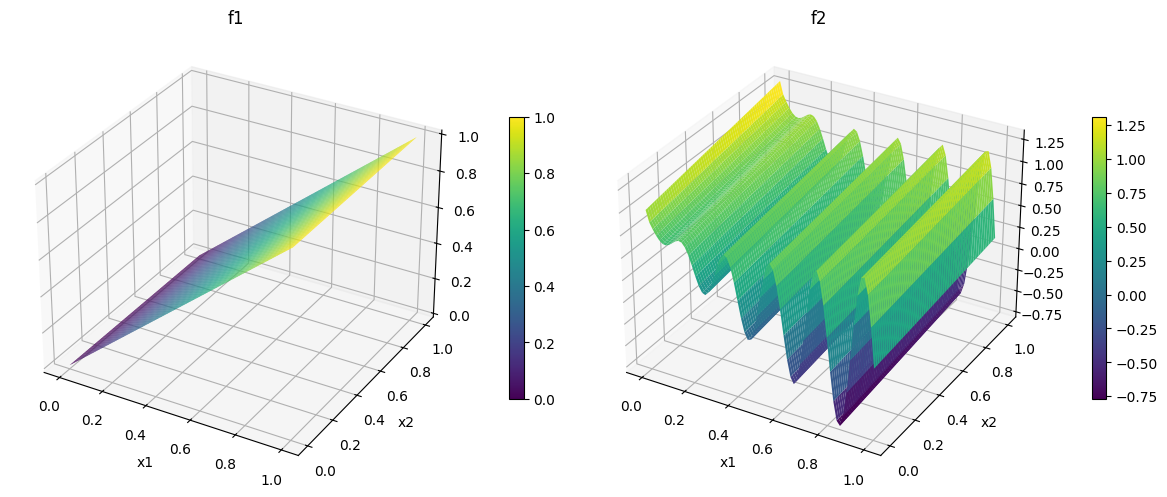

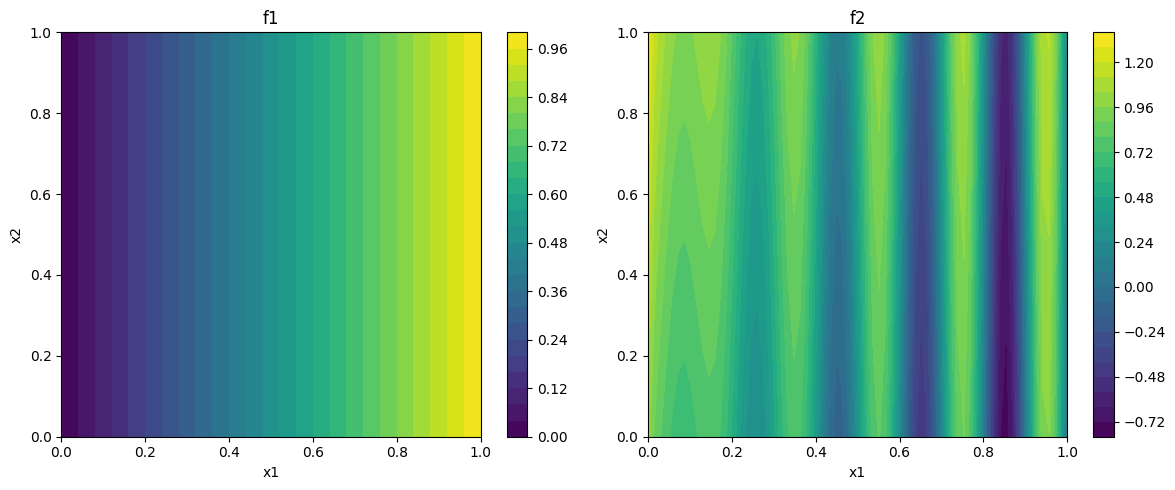

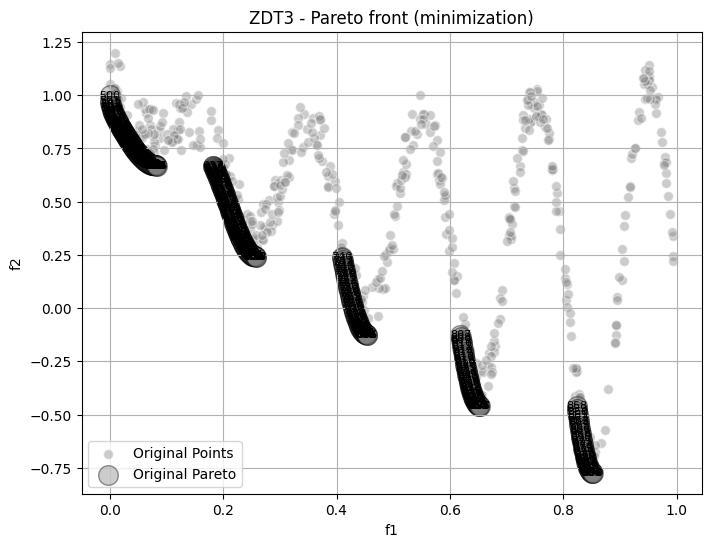

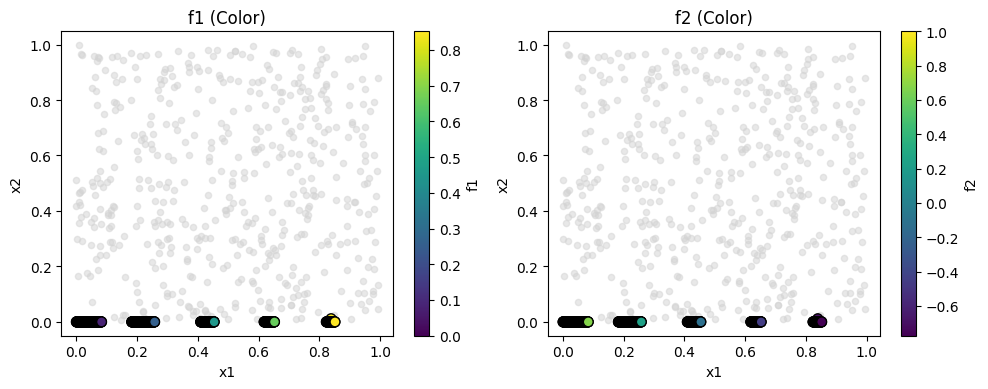

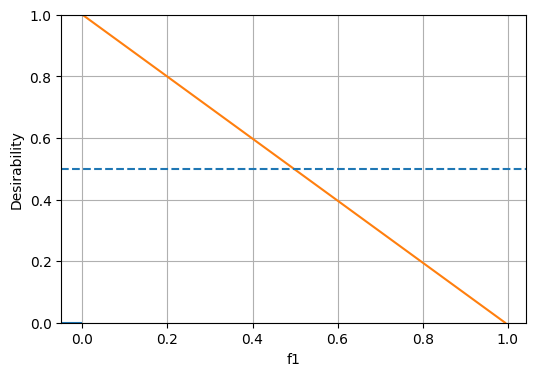

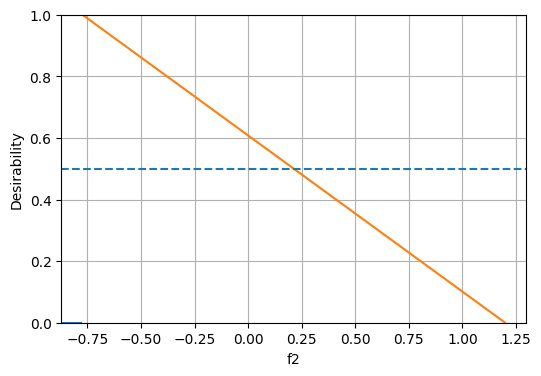

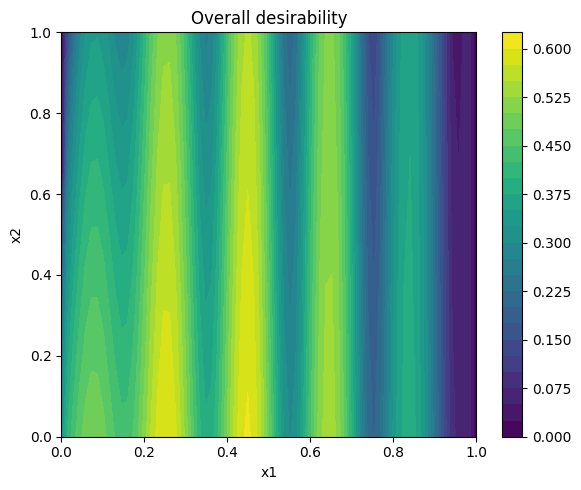

ZDT3 STEP 2 DONE


In [8]:
# ============================================================
# ZDT3 — Step 1: Data generation
# ============================================================


print("ZDT3: Disconnected Pareto Front")
print("-" * 60)

# -------------------------
# Sampling
# -------------------------
n_nonopt = 500      # non-opt samples on 2D slice (x1, x2)
n_pareto = 400      # Pareto samples (true PF, disconnected segments)

# -------------------------
# Helper: nondominated mask in 2D minimization
# -------------------------
def _nondominated_mask_2d(f1, f2):
    # sort by f1 ascending; keep points that improve (decrease) best f2 so far
    idx = np.argsort(f1)
    best_f2 = np.inf
    mask = np.zeros_like(f1, dtype=bool)
    for i in idx:
        if f2[i] <= best_f2 + 1e-12:
            mask[i] = True
            best_f2 = f2[i]
    return mask

def _zdt3_true_pf_x0(n_points, dense=200000):
    """
    Build x1 samples ONLY from the true disconnected PF segments.
    PF condition: x2..x(n-1) = 0 => g = 1
    Then: f1 = x1
          f2 = 1 - sqrt(x1) - x1*sin(10*pi*x1)
    True PF are the nondominated parts (disconnected in f-space).
    """
    x = np.linspace(0.0, 1.0, dense + 1)
    f1 = x
    f2 = 1 - np.sqrt(x) - x * np.sin(10 * np.pi * x)

    mask = _nondominated_mask_2d(f1, f2)
    x_nd = x[mask]

    # find contiguous segments in x_nd
    dx = x[1] - x[0]
    gap_idx = np.where(np.diff(x_nd) > 1.5 * dx)[0]

    segments = []
    s = 0
    for g in gap_idx:
        segments.append((x_nd[s], x_nd[g]))
        s = g + 1
    segments.append((x_nd[s], x_nd[-1]))

    # allocate points proportional to segment length (deterministic)
    lengths = np.array([b - a for a, b in segments])
    weights = lengths / lengths.sum()
    n_per = np.maximum(2, np.floor(weights * n_points).astype(int))

    # fix rounding to match exactly n_points
    while n_per.sum() < n_points:
        n_per[np.argmax(lengths)] += 1
    while n_per.sum() > n_points:
        i = np.argmax(n_per)
        if n_per[i] > 2:
            n_per[i] -= 1
        else:
            j = np.argmax(np.where(n_per > 2, n_per, -1))
            n_per[j] -= 1

    xs = []
    for (a, b), ni in zip(segments, n_per):
        xs.append(np.linspace(a, b, ni))
    x_pf = np.concatenate(xs)

    # safety
    x_pf = np.clip(x_pf, 0.0, 1.0)
    if x_pf.size != n_points:
        x_pf = x_pf[:n_points]

    return x_pf, segments

# -------------------------
# 1) Non-optimal (2D slice)
# -------------------------
X_nonopt_2d = np.random.rand(n_nonopt, 2)   # x1, x2 ~ U(0,1)

# -------------------------
# 2) TRUE Pareto points (ONLY true disconnected PF segments)
#    PF condition: x2..x29 = 0, only x1 varies, BUT only on specific segments.
#    In the 2D slice: x2 = 0 and x1 lies on the PF segments.
# -------------------------
x0_pf, segs = _zdt3_true_pf_x0(n_pareto, dense=200000)
X_pareto_2d = np.column_stack([x0_pf, np.zeros(n_pareto)])  # (x1, x2=0)

# -------------------------
# 3) Combine
# -------------------------
X_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
n_samples = X_2d.shape[0]

# -------------------------
# 4) Pad to 30D (x3..x29 = 0)
# -------------------------
n_var = 30
fixed_value = 0.0
pair_opt = (0, 1)

X_full = np.full((n_samples, n_var), fixed_value, dtype=float)
X_full[:, 0] = X_2d[:, 0]  # x1
X_full[:, 1] = X_2d[:, 1]  # x2

# Evaluate ZDT3 with full 30D input (analytic)
y_samples = zdt3(X_full)

# -------------------------
# Shared pipeline parameters
# -------------------------
func_name = "ZDT3"
test_func = zdt3

pairs = [(0, 1)]
n_grid = 70
bounds = ((0, 1), (0, 1))
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = None  # ZDT3 does not need kwargs

# Grid data (analytic evaluation on the grid)
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

# Desirability objects + desirability grid (from sample ranges)
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"Non-optimal samples (2D slice): {n_nonopt}")
print(f"Pareto samples (true PF segments, x2=0): {n_pareto}")
print(f"Total samples used for plots: {n_samples}")
print(f"Objective space shape: {y_samples.shape}")
print(f"f1 range: [{y_samples[:, 0].min():.4f}, {y_samples[:, 0].max():.4f}]")
print(f"f2 range: [{y_samples[:, 1].min():.4f}, {y_samples[:, 1].max():.4f}]")
print("PF segments in x1 (approx):")
for a, b in segs:
    print(f"  [{a:.6f}, {b:.6f}]")

print(f"{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))

# ============================================================
# ZDT3 — Step 2: Visualization
# Note: scatter-only Pareto plot is used here because ZDT3 has a
# disconnected Pareto front; drawing a continuous PF line would be misleading.
# ============================================================

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_scatter_only(
    y_samples,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=is_minimization,
    var_names=("x1", "x2"),
    target_names=target_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

ZDT4: Multimodal
------------------------------------------------------------
Non-optimal samples (2D slice): 1000
Pareto samples (true PF, x2=0): 200
Total samples used for plots: 1200
Objective space shape: (1200, 2)
f1 range: [0.0000, 1.0000]
f2 range: [0.0000, 42.6749]
ZDT4 STEP 1 DONE
grid_data keys: [(0, 1)]


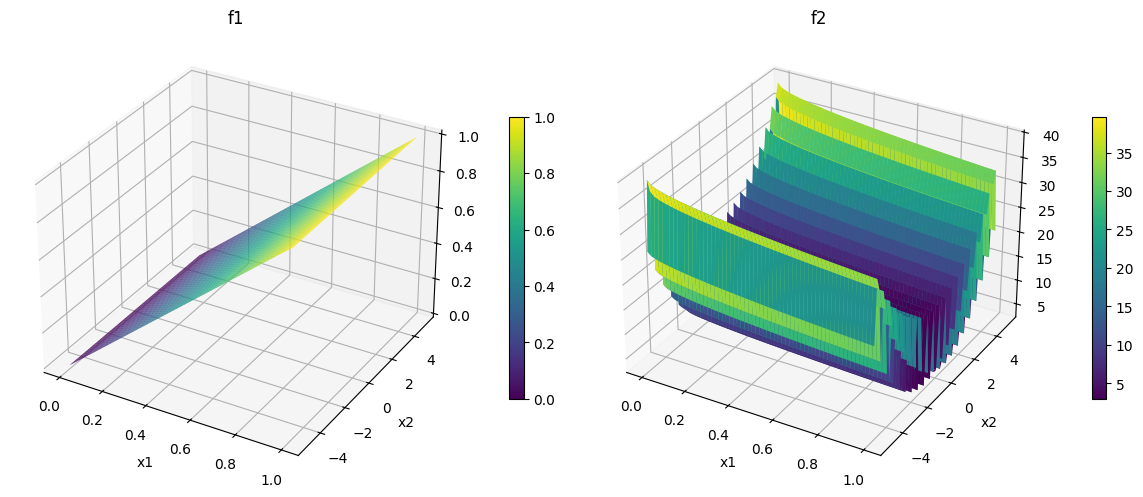

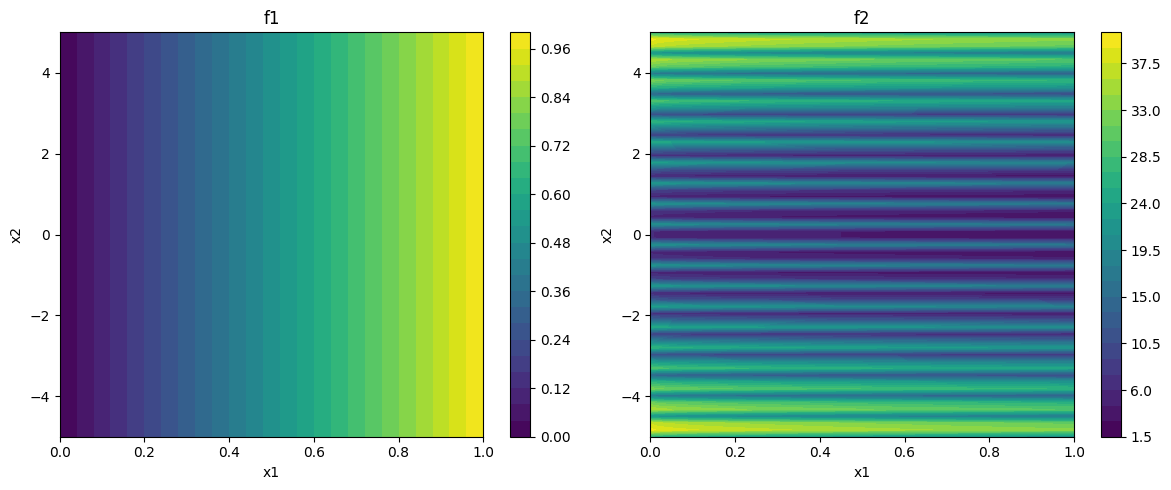

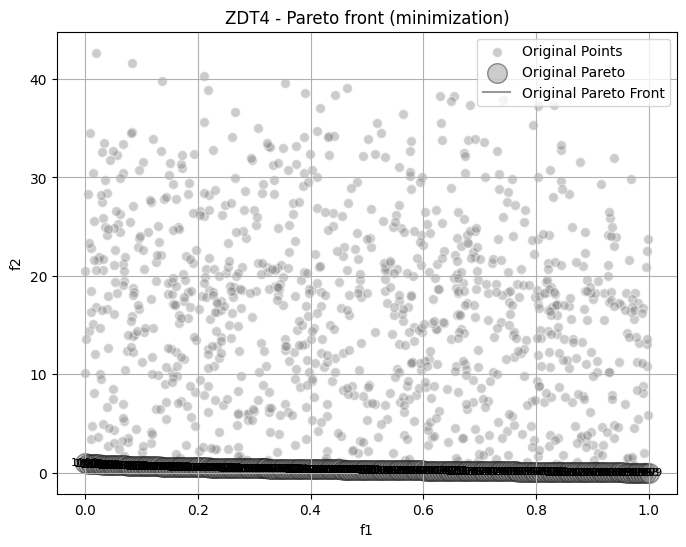

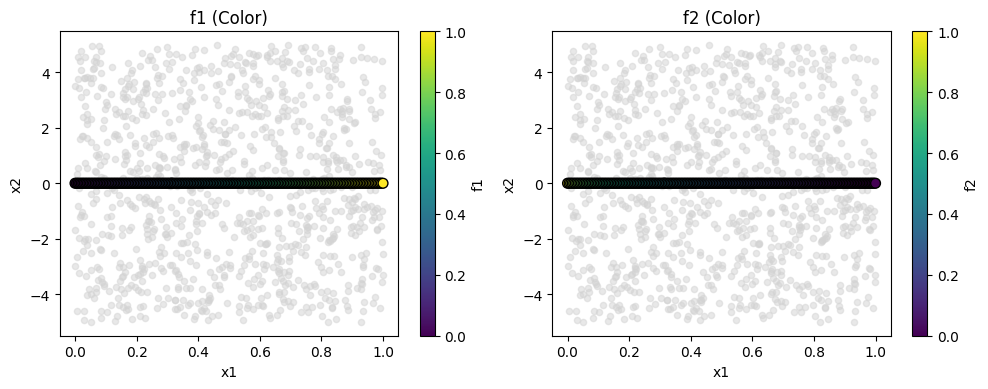

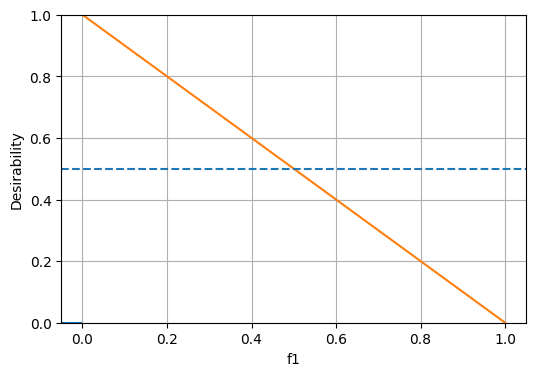

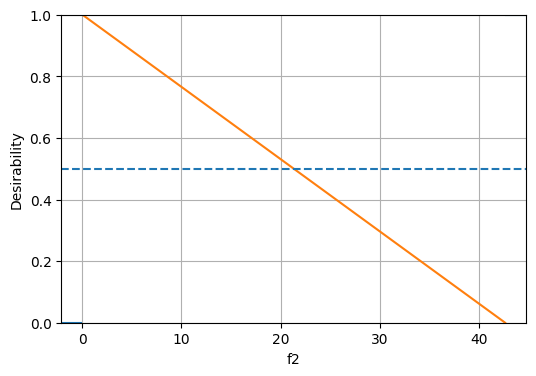

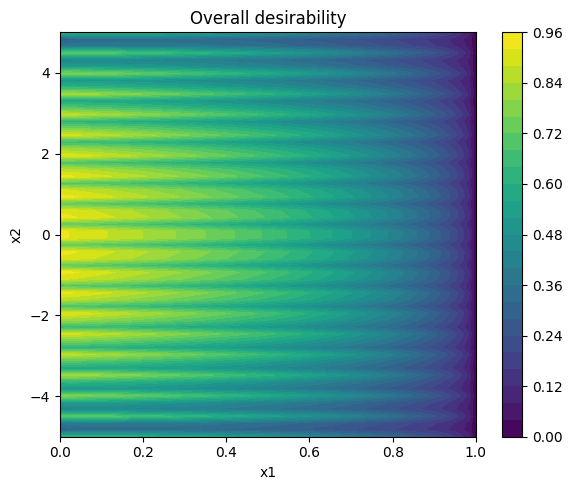

ZDT4 STEP 2 DONE


In [9]:
# ============================================================
# ZDT4 — Step 1: Data generation
# ============================================================


print("ZDT4: Multimodal")
print("-" * 60)

# -------------------------
# Sampling
# -------------------------
n_nonopt = 1000     # non-opt samples on 2D slice (x1, x2)
n_pareto = 200      # Pareto samples

# NOTE:
# Standard ZDT4: x1 in [0,1], x2..x10 in [-5,5]
# For the 2D slice visualization, we vary:
#   x1 in [0,1] and x2 in [-5,5]
X_nonopt_2d = np.column_stack([
    np.random.rand(n_nonopt),                 # x1 ~ U(0,1)
    np.random.uniform(-5, 5, size=n_nonopt)   # x2 ~ U(-5,5)
])

# TRUE Pareto points:
# PF when x2..x10 = 0, only x1 varies in [0,1]
x0_range = np.linspace(0, 1, n_pareto)
X_pareto_2d = np.column_stack([x0_range, np.zeros(n_pareto)])  # (x1, x2=0)

# Combine both
X_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
n_samples = X_2d.shape[0]

# Build full 10D vectors for ZDT4 evaluation (x3..x10 fixed at 0)
n_var = 10
fixed_value = 0.0
pair_opt = (0, 1)

X_full = np.full((n_samples, n_var), fixed_value, dtype=float)
X_full[:, 0] = X_2d[:, 0]  # x1 in [0,1]
X_full[:, 1] = X_2d[:, 1]  # x2 in [-5,5]
# X_full[:, 2:10] remain 0

# Evaluate ZDT4 with full 10D input (analytic)
y_samples = zdt4(X_full)

# -------------------------
# Shared pipeline parameters
# -------------------------
func_name = "ZDT4"
test_func = zdt4

pairs = [(0, 1)]
n_grid = 60                       # keep smaller for speed (multimodal)
bounds = ((0, 1), (-5, 5))        # ZDT4 slice bounds
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = None                # ZDT4 does not need kwargs

# Grid data (analytic evaluation on the grid)
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

# Desirability objects + desirability grid (from sample ranges)
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"Non-optimal samples (2D slice): {n_nonopt}")
print(f"Pareto samples (true PF, x2=0): {n_pareto}")
print(f"Total samples used for plots: {n_samples}")
print(f"Objective space shape: {y_samples.shape}")
print(f"f1 range: [{y_samples[:, 0].min():.4f}, {y_samples[:, 0].max():.4f}]")
print(f"f2 range: [{y_samples[:, 1].min():.4f}, {y_samples[:, 1].max():.4f}]")

print(f"{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))

# ============================================================
# ZDT4 — Step 2: Visualization
# ============================================================

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(
    y_samples,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=is_minimization,
    var_names=("x1", "x2"),
    target_names=target_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

ZDT6: Non-uniform Pareto Front Density
------------------------------------------------------------
Non-optimal samples (2D slice): 500
Pareto samples (true PF, x2=0): 600
Total samples used for plots: 1100
Objective space shape: (1100, 2)
f1 range: [0.2808, 1.0000]
f2 range: [0.0000, 6.1280]
ZDT6 STEP 1 DONE
grid_data keys: [(0, 1)]


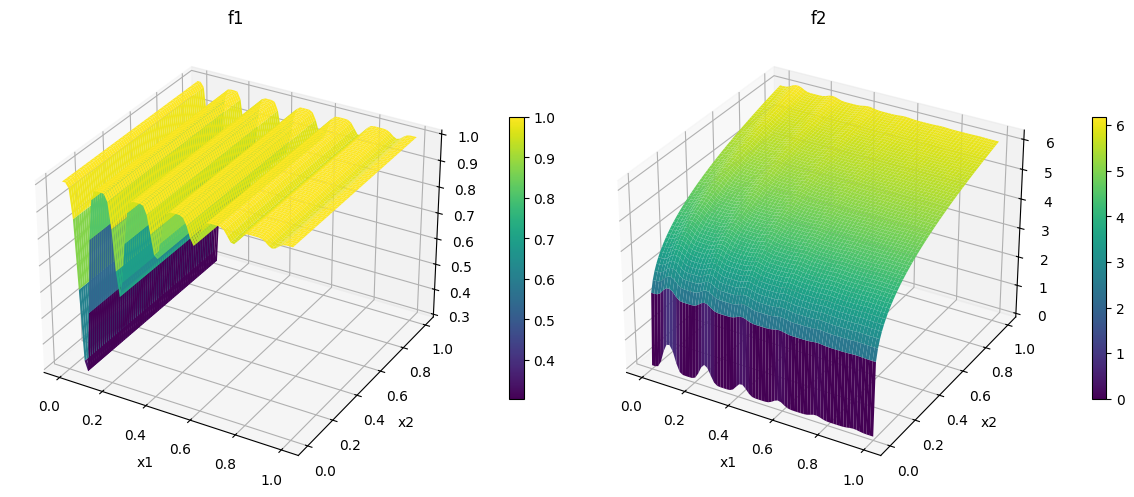

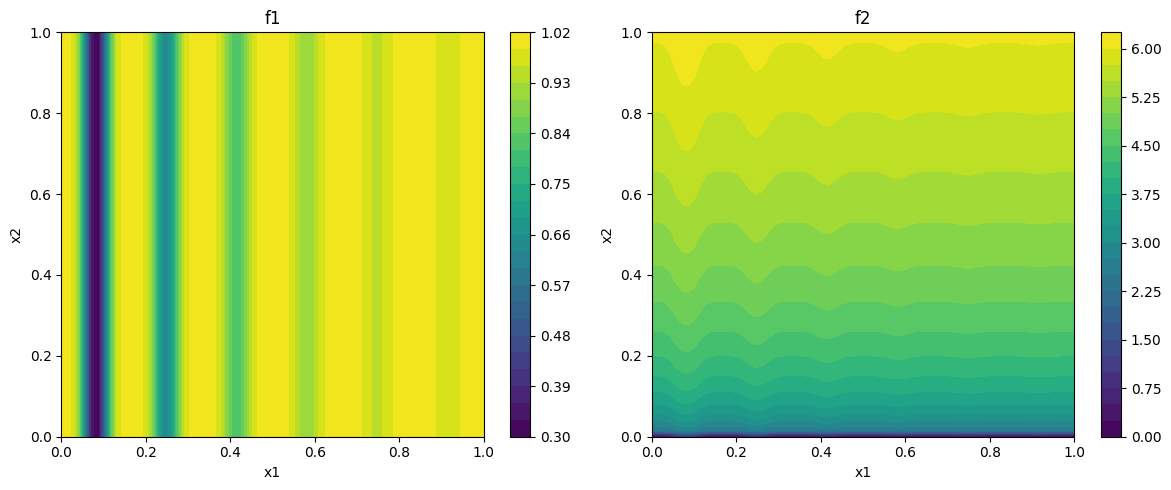

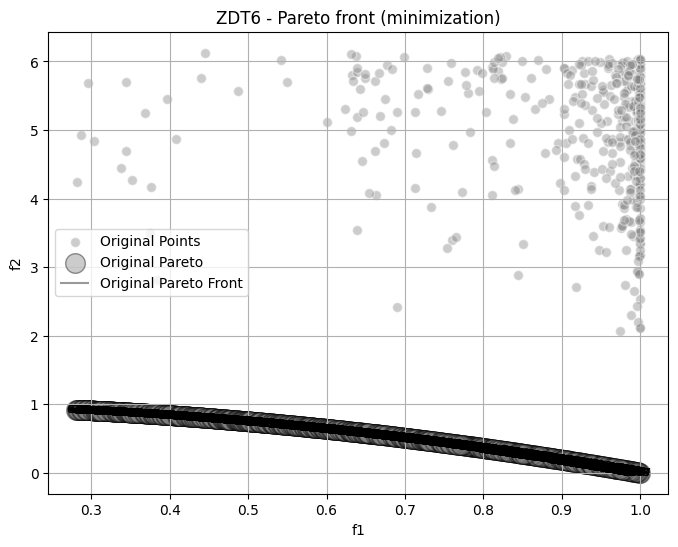

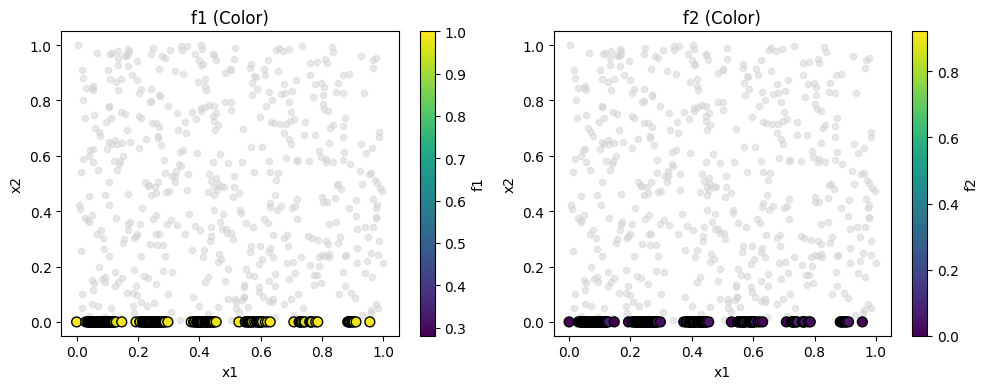

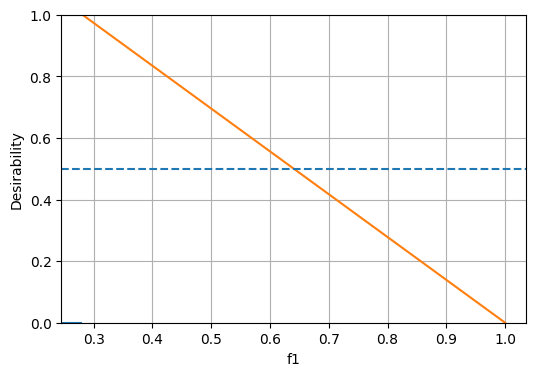

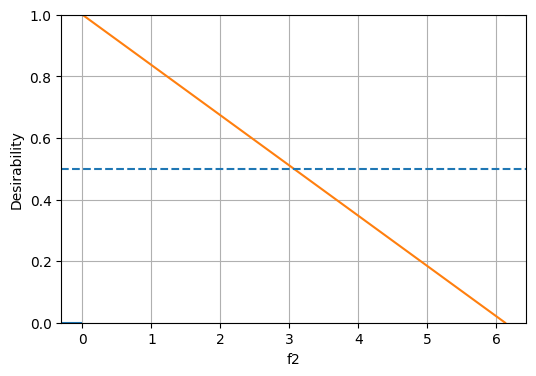

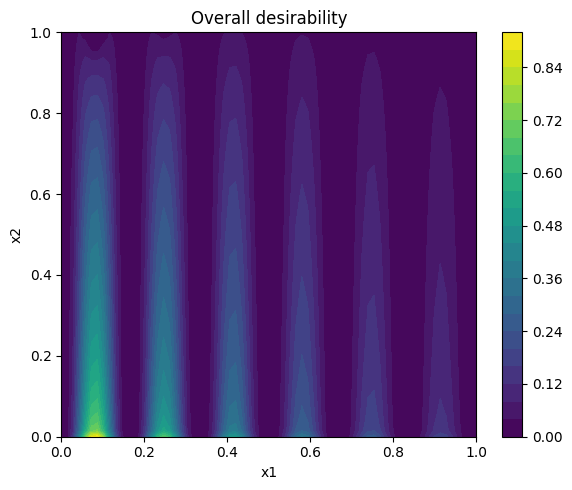

ZDT6 STEP 2 DONE


In [10]:
# ============================================================
# ZDT6 — Step 1: Data generation
# ============================================================


print("ZDT6: Non-uniform Pareto Front Density")
print("-" * 60)

# -------------------------
# Sampling
# -------------------------
n_nonopt = 500
n_pareto = 600      # increased for better PF coverage

# 1) Non-optimal (2D slice)
X_nonopt_2d = np.random.rand(n_nonopt, 2)   # x1, x2 ~ U(0,1)

# 2) UNIFORM sampling in f1 space (objective space)
# Dense mapping x1 -> f1
x0_dense = np.linspace(0, 1, 100000)
f1_dense = 1 - np.exp(-4 * x0_dense) * np.sin(6 * np.pi * x0_dense) ** 6

f1_min = f1_dense.min()
f1_max = f1_dense.max()

# Sample f1 uniformly in objective space
f1_uniform = np.linspace(f1_min, f1_max, n_pareto)

# Invert numerically: for each f1, find x1 that matches it (closest)
x0_range = np.zeros(n_pareto, dtype=float)
for i, f1_target in enumerate(f1_uniform):
    idx = np.argmin(np.abs(f1_dense - f1_target))
    x0_range[i] = x0_dense[idx]

# Remove duplicates and ensure enough points
x0_range_unique = np.unique(x0_range)

if len(x0_range_unique) < n_pareto * 0.9:
    # Add extra points to fill gaps
    x0_extra = np.linspace(0.001, 1.0, n_pareto - len(x0_range_unique))
    x0_range = np.sort(np.concatenate([x0_range_unique, x0_extra]))[:n_pareto]
else:
    x0_range = x0_range_unique[:n_pareto]

# Pareto points on the slice: x2 = 0
X_pareto_2d = np.column_stack([x0_range, np.zeros(len(x0_range))])

# 3) Combine both
X_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
n_samples = X_2d.shape[0]

# 4) Build full 10D vectors for ZDT6 evaluation (x3..x10 fixed at 0)
n_var = 10
fixed_value = 0.0
pair_opt = (0, 1)

X_full = np.full((n_samples, n_var), fixed_value, dtype=float)
X_full[:, 0] = X_2d[:, 0]   # x1
X_full[:, 1] = X_2d[:, 1]   # x2

# Evaluate ZDT6 with full input (analytic)
y_samples = zdt6(X_full)

# -------------------------
# Shared pipeline parameters
# -------------------------
func_name = "ZDT6"
test_func = zdt6

pairs = [(0, 1)]
n_grid = 70
bounds = ((0, 1), (0, 1))
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = None  # ZDT6 does not need kwargs

# Grid data (analytic evaluation on the grid)
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

# Desirability objects + desirability grid (from sample ranges)
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"Non-optimal samples (2D slice): {n_nonopt}")
print(f"Pareto samples (true PF, x2=0): {len(x0_range)}")
print(f"Total samples used for plots: {n_samples}")
print(f"Objective space shape: {y_samples.shape}")
print(f"f1 range: [{y_samples[:, 0].min():.4f}, {y_samples[:, 0].max():.4f}]")
print(f"f2 range: [{y_samples[:, 1].min():.4f}, {y_samples[:, 1].max():.4f}]")

print(f"{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))

# ============================================================
# ZDT6 — Step 2: Visualization
# ============================================================

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(
    y_samples,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=is_minimization,
    var_names=("x1", "x2"),
    target_names=target_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

In [11]:
# DTLZ function implementations
# Reference: Deb et al. (2002)

def dtlz1(X, n_obj=2):
    """
    DTLZ1: Linear Pareto front
    Reference: Deb et al. (2002)
    """
    n_var = X.shape[1]
    k = n_var - n_obj + 1
    
    # g-function uses last k variables
    XM = X[:, n_obj-1:]
    g = 100 * (k + np.sum((XM - 0.5)**2 - np.cos(20 * np.pi * (XM - 0.5)), axis=1))
    
    f = []
    for i in range(n_obj):
        _f = 0.5 * (1 + g)
        
        # Multiply by the first (n_obj - i - 1) decision variables
        for j in range(n_obj - i - 1):
            _f *= X[:, j]
        
        # For all except first objective, multiply by (1 - x[n_obj - i - 1])
        if i > 0:
            _f *= (1 - X[:, n_obj - i - 1])
        
        f.append(_f)
    
    return np.column_stack(f)



def dtlz2(x: np.ndarray, n_obj: int = 3, n: int = None) -> np.ndarray:
    """DTLZ2 (spherical/concave Pareto front). Domain: x ∈ [0,1]^n."""
    X, was_1d = _as_2d(x)
    n = _infer_n(X, n_obj)
    _check_dims(X, n_obj, n)

    X_M = X[:, n_obj-1:]
    g = np.sum((X_M - 0.5) ** 2, axis=1)

    F = np.empty((X.shape[0], n_obj), dtype=float)
    for m in range(n_obj):
        val = 1.0 + g
        for i in range(n_obj - m - 1):
            val *= np.cos(0.5 * np.pi * X[:, i])
        if m > 0:
            val *= np.sin(0.5 * np.pi * X[:, n_obj - m - 1])
        F[:, m] = val

    return F[0] if was_1d else F 


def dtlz3(X, n_obj=2):
    """
    DTLZ3: Concave with multimodality
    Reference: Deb et al. (2002)
    """
    n_var = X.shape[1]
    k = n_var - n_obj + 1
    
    # g-function uses last k variables (multimodal like DTLZ1)
    XM = X[:, n_obj-1:]
    g = 100 * (k + np.sum((XM - 0.5)**2 - np.cos(20 * np.pi * (XM - 0.5)), axis=1))
    
    f = []
    for i in range(n_obj):
        _f = (1 + g)
        
        # Multiply by cos terms for first (n_obj - i - 1) variables
        for j in range(n_obj - i - 1):
            _f *= np.cos(X[:, j] * np.pi / 2)
        
        # For all except first objective, multiply by sin term
        if i > 0:
            _f *= np.sin(X[:, n_obj - i - 1] * np.pi / 2)
        
        f.append(_f)
    
    return np.column_stack(f)

def dtlz4(X, n_obj=2, alpha=100):
    """
    DTLZ4: Concave with biased density
    Reference: Deb et al. (2002)
    """
    n_var = X.shape[1]
    k = n_var - n_obj + 1
    
    # g-function uses last k variables
    XM = X[:, n_obj-1:]
    g = np.sum((XM - 0.5)**2, axis=1)
    
    # Apply power transformation ONLY to first (n_obj-1) variables
    X_alpha = X[:, :n_obj-1] ** alpha
    
    f = []
    for i in range(n_obj):
        _f = (1 + g)
        
        # Multiply by cos terms using X_alpha
        for j in range(n_obj - i - 1):
            _f *= np.cos(X_alpha[:, j] * np.pi / 2)
        
        # For all except first objective, multiply by sin term
        if i > 0:
            _f *= np.sin(X_alpha[:, n_obj - i - 1] * np.pi / 2)
        
        f.append(_f)
    
    return np.column_stack(f)

def dtlz5(X, n_obj=2):
    """
    DTLZ5: Degenerate Pareto front
    Reference: Deb et al. (2002)
    """
    n_var = X.shape[1]
    k = n_var - n_obj + 1
    
    # g-function uses last k variables
    XM = X[:, n_obj-1:]
    g = np.sum((XM - 0.5)**2, axis=1)
    
    # Angle mapping
    theta = []
    theta.append(X[:, 0] * np.pi / 2)
    for i in range(1, n_obj - 1):
        theta.append((np.pi / (4 * (1 + g))) * (1 + 2 * g * X[:, i]))
    
    f = []
    for i in range(n_obj):
        _f = (1 + g)
        
        # Multiply by cos terms
        for j in range(n_obj - i - 1):
            _f *= np.cos(theta[j])
        
        # For all except first objective, multiply by sin term
        if i > 0:
            _f *= np.sin(theta[n_obj - i - 1])
        
        f.append(_f)
    
    return np.column_stack(f)

import numpy as np

def dtlz6(X, n_obj=2):
    """
    DTLZ6 (Deb et al.): like DTLZ5 but with g(x_M) = sum(x_i^0.1)
    Domain: x in [0, 1]
    """
    X = np.atleast_2d(X).astype(float)
    n_var = X.shape[1]
    if n_var < n_obj:
        raise ValueError(f"n_var must be >= n_obj (got n_var={n_var}, n_obj={n_obj})")

    # k = n_var - n_obj + 1
    XM = X[:, n_obj-1:]                 # last k vars
    g = np.sum(np.power(XM, 0.1), axis=1)

    # theta mapping (same as DTLZ5)
    theta = [X[:, 0] * np.pi / 2.0]
    for i in range(1, n_obj - 1):
        theta.append((np.pi / (4.0 * (1.0 + g))) * (1.0 + 2.0 * g * X[:, i]))

    f = []
    for i in range(n_obj):
        _f = (1.0 + g)
        for j in range(n_obj - i - 1):
            _f *= np.cos(theta[j])
        if i > 0:
            _f *= np.sin(theta[n_obj - i - 1])
        f.append(_f)

    return np.column_stack(f)

def dtlz7(X, n_obj=2):
    """
    DTLZ7: Mixed Pareto front geometries
    Reference: Deb et al. (2002)
    """
    n_var = X.shape[1]
    k = n_var - n_obj + 1
    
    # g-function uses last k variables
    XM = X[:, n_obj-1:]
    g = 1 + (9 / k) * np.sum(XM, axis=1)
    
    # First (n_obj - 1) objectives are just the variables
    f = []
    for i in range(n_obj - 1):
        f.append(X[:, i])
    
    # Last objective uses h-function
    h = n_obj - np.sum([f[i] / (1 + g) * (1 + np.sin(3 * np.pi * f[i])) 
                        for i in range(n_obj - 1)], axis=0)
    f.append((1 + g) * h)
    
    return np.column_stack(f)

print("DTLZ functions implemented successfully!")

DTLZ functions implemented successfully!


DTLZ1: Linear Pareto Front (2 objectives)
------------------------------------------------------------
Non-optimal samples (2D slice): 200
Pareto samples (true PF, x2..x6=0.5): 200
Total samples used for plots: 400
Objective space shape: (400, 2)
f1 range: [0.0000, 2.5795]
f2 range: [0.0000, 2.4876]
PF check (injected): mean(f1+f2) = 0.500000 (expected 0.5)
DTLZ1 STEP 1 DONE
grid_data keys: [(0, 1)]


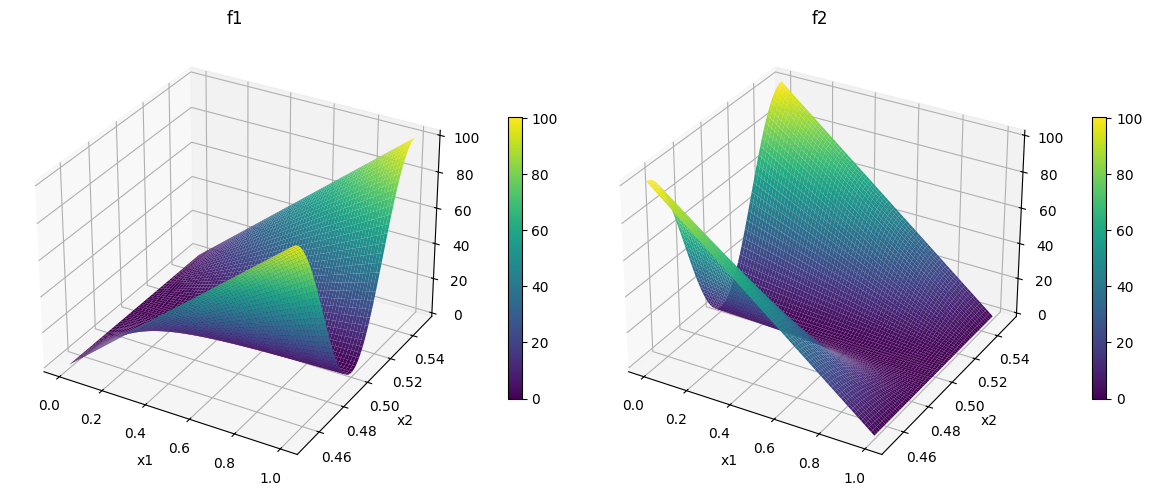

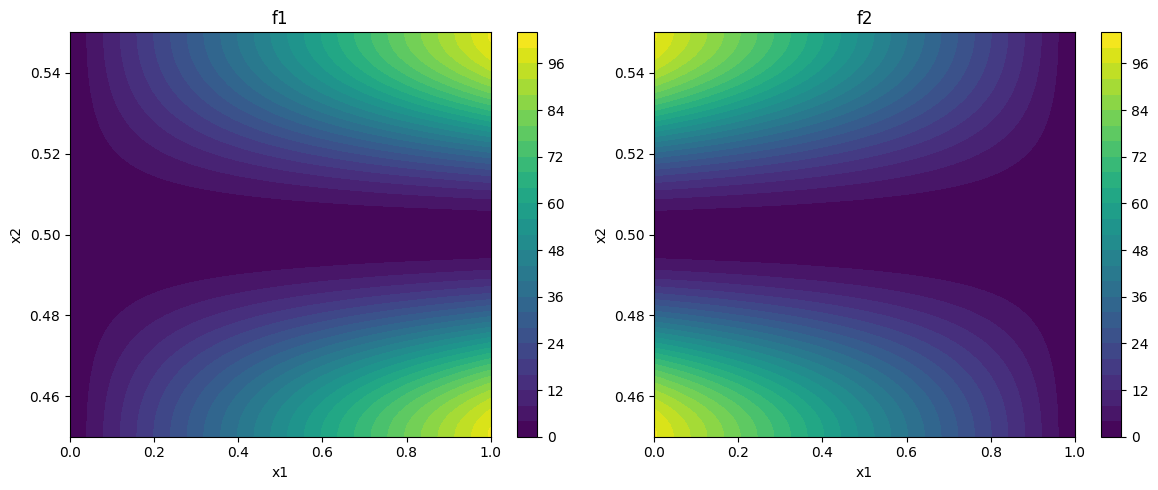

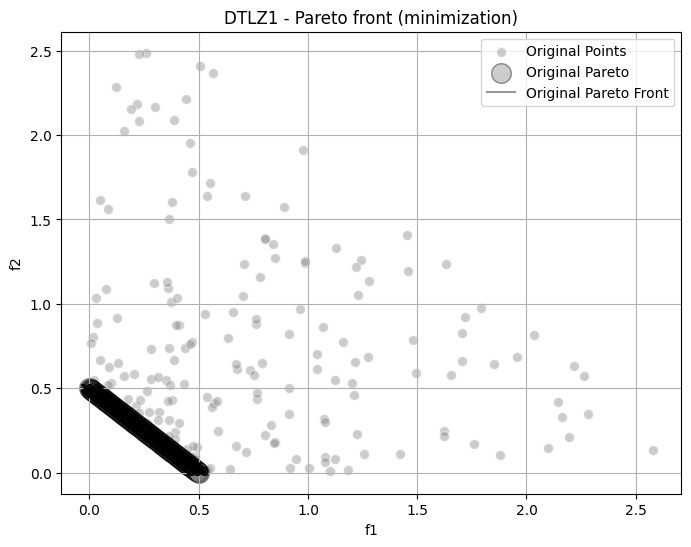

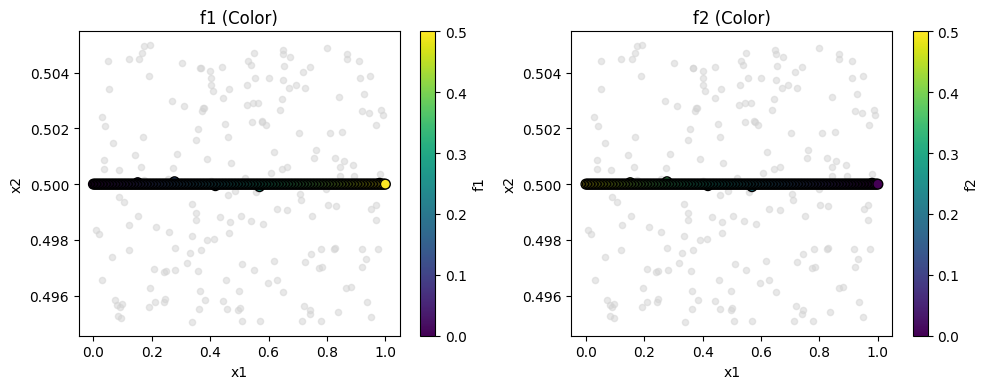

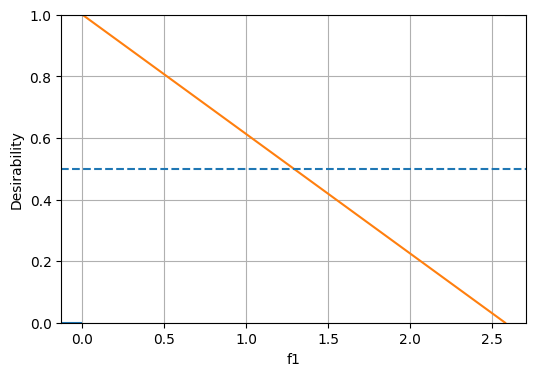

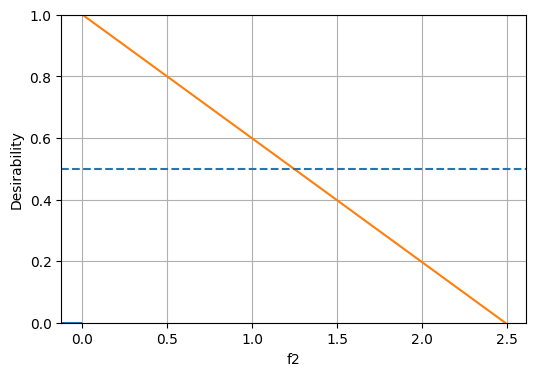

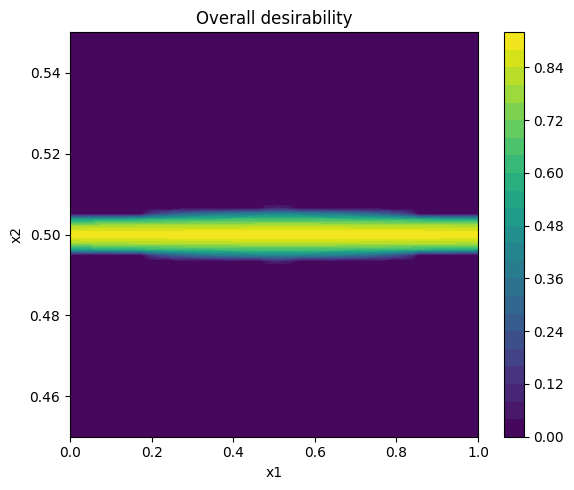

DTLZ1 STEP 2 DONE


In [12]:
# ============================================================
# DTLZ1 — Step 1: Data generation
# ============================================================

from spotoptim.function.mo import dtlz1
import numpy as np

print("DTLZ1: Linear Pareto Front (2 objectives)")
print("-" * 60)

# -------------------------
# Problem setup
# -------------------------
n_obj = 2
n_var = 6                  # common: M=2, k=5  => n = M + k - 1 = 6
n_nonopt = 200
n_pareto = 200

pair_opt = (0, 1)          # slice variables: x1 and x2
fixed_value = 0.5          # for DTLZ1 PF we want x2..x6 = 0.5

# -------------------------
# Helper: g(x) for DTLZ1
# -------------------------
def dtlz1_g(X, n_obj=2):
    X = np.asarray(X, dtype=float)
    n_var_local = X.shape[1]
    k = n_var_local - n_obj + 1
    XM = X[:, n_obj-1:]  # for M=2 -> from x2 to x6
    return 100.0 * (k + np.sum((XM - 0.5)**2 - np.cos(20.0 * np.pi * (XM - 0.5)), axis=1))

# -------------------------
# 1) Non-optimal samples on 2D slice
#    Keep x2 close to 0.5; fix x3..x6 = 0.5 to avoid huge g explosion.
# -------------------------
X_nonopt_2d = np.zeros((n_nonopt, 2), dtype=float)
X_nonopt_2d[:, 0] = np.random.rand(n_nonopt)                         # x1 in [0,1]
X_nonopt_2d[:, 1] = 0.5 + 0.01 * (np.random.rand(n_nonopt) - 0.5)    # x2 around 0.5

# -------------------------
# 2) TRUE Pareto points
#    For DTLZ1 (M=2): Pareto-optimal when x2..x6 = 0.5, only x1 varies.
#    In the slice: x2=0.5, x1 spans [0,1]
# -------------------------
x0_range = np.linspace(0, 1, n_pareto)
X_pareto_2d = np.column_stack([x0_range, np.full(n_pareto, 0.5)])

# -------------------------
# 3) Combine
# -------------------------
X_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
n_samples = X_2d.shape[0]

# -------------------------
# 4) Embed into full 6D
#    - non-opt: x3..x6 = 0.5 (keeps g moderate)
#    - pareto: x2..x6 = 0.5 (g=0)
# -------------------------
X_full = np.full((n_samples, n_var), 0.5, dtype=float)  # default all 0.5
X_full[:, 0] = X_2d[:, 0]                               # x1
X_full[:, 1] = X_2d[:, 1]                               # x2

# For the injected PF points, enforce exact PF condition (x2..x6 = 0.5)
X_full[n_nonopt:, 1:] = 0.5

# Evaluate DTLZ1 (analytic)
y_samples = dtlz1(X_full, n_obj=n_obj)

print(f"Non-optimal samples (2D slice): {n_nonopt}")
print(f"Pareto samples (true PF, x2..x6=0.5): {n_pareto}")
print(f"Total samples used for plots: {n_samples}")
print(f"Objective space shape: {y_samples.shape}")
print(f"f1 range: [{y_samples[:, 0].min():.4f}, {y_samples[:, 0].max():.4f}]")
print(f"f2 range: [{y_samples[:, 1].min():.4f}, {y_samples[:, 1].max():.4f}]")

pf_sum = y_samples[n_nonopt:, 0] + y_samples[n_nonopt:, 1]
print(f"PF check (injected): mean(f1+f2) = {pf_sum.mean():.6f} (expected 0.5)")

# -------------------------
# Pipeline parameters
# -------------------------
func_name = "DTLZ1"
test_func = dtlz1

pairs = [pair_opt]
n_grid = 70

# IMPORTANT:
# For DTLZ1, if x2 moves far from 0.5, g can explode => huge objectives.
# So we limit the grid slice range for x2 around 0.5.
bounds = ((0, 1), (0.45, 0.55))   # x1 in [0,1], x2 near 0.5

target_names = ("f1", "f2")
is_minimization = True
func_kwargs = {"n_obj": n_obj}

# Grid data (analytic evaluation on the grid)
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,     # other vars fixed at 0.5
    func_kwargs=func_kwargs
)

# Desirability objects + desirability grid
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))

# ============================================================
# DTLZ1 — Step 2: Visualization
# ============================================================

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(
    y_samples,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=is_minimization,
    var_names=("x1", "x2"),
    target_names=target_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

DTLZ2: Concave Pareto Front (2 objectives) — TRUE 2D slice sampling
------------------------------------------------------------
Non-opt samples (TRUE 2D slice): 200
Pareto samples (x2=0.5 line, TRUE PF on slice): 300
Total samples: 500
Objective space shape: (500, 2)
f1 range: [0.0000, 1.1828]
f2 range: [0.0000, 1.2413]
PF check: mean sqrt(f1^2+f2^2) = 1.000000 (expected ~1.0)
DTLZ2 STEP 1 DONE
grid_data keys: [(0, 1)]


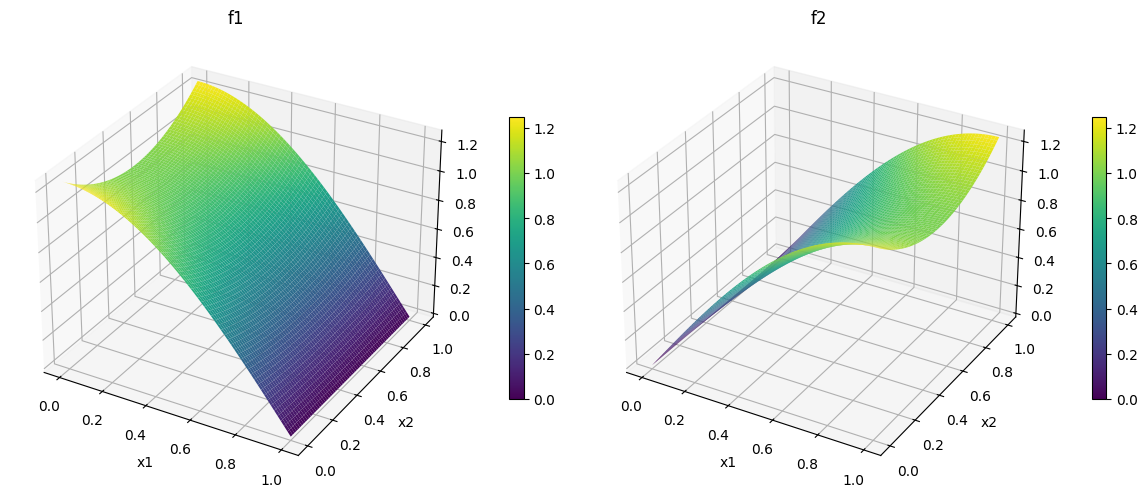

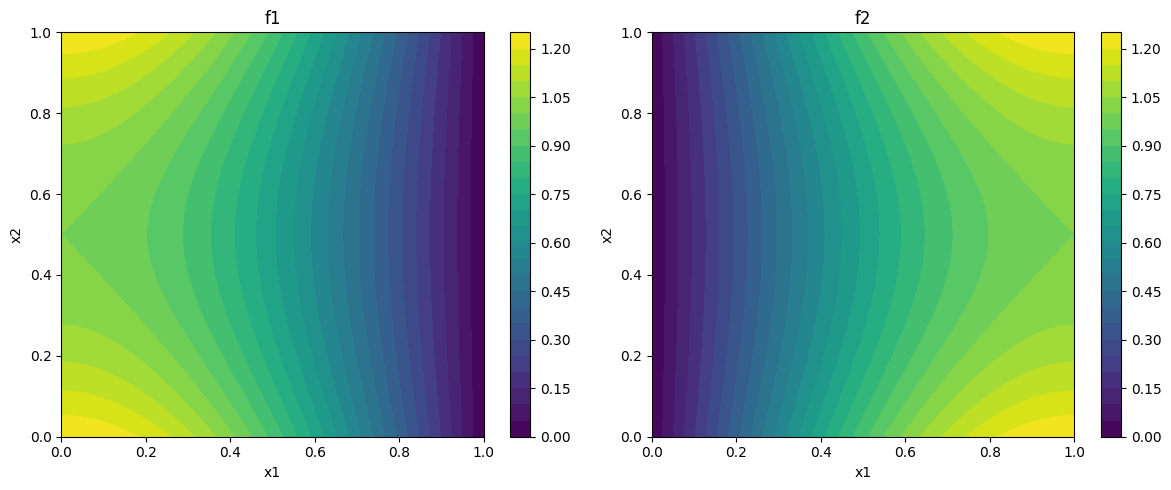

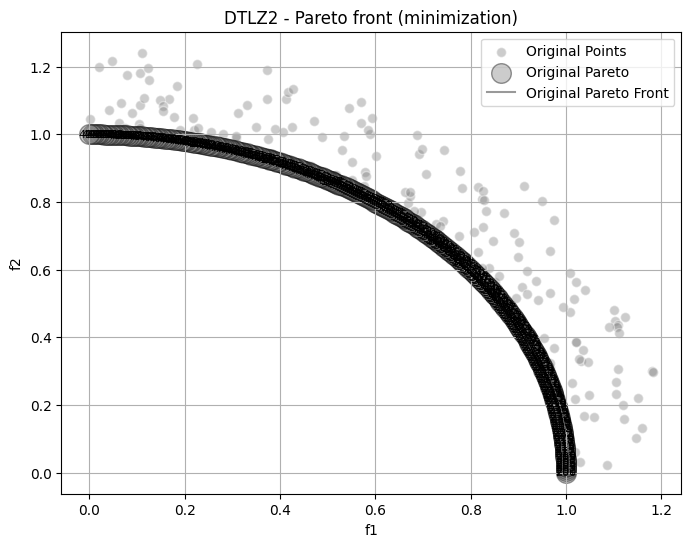

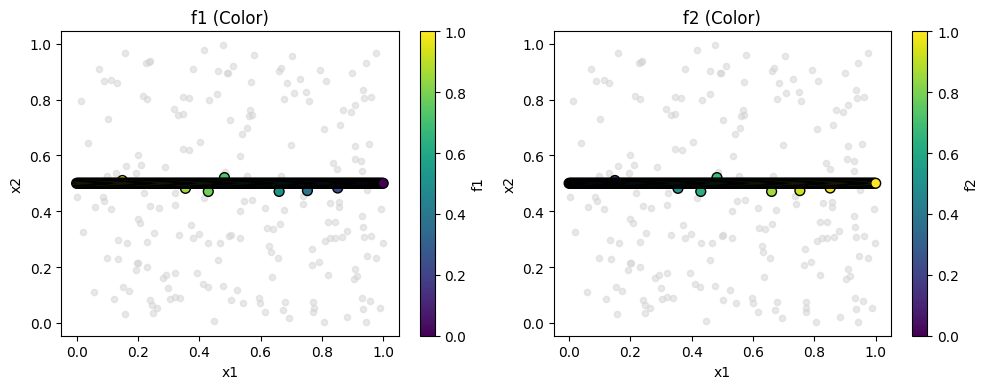

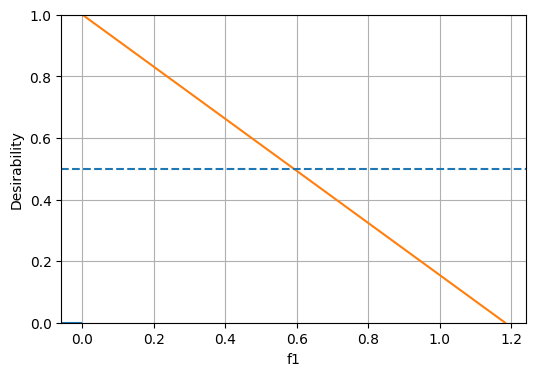

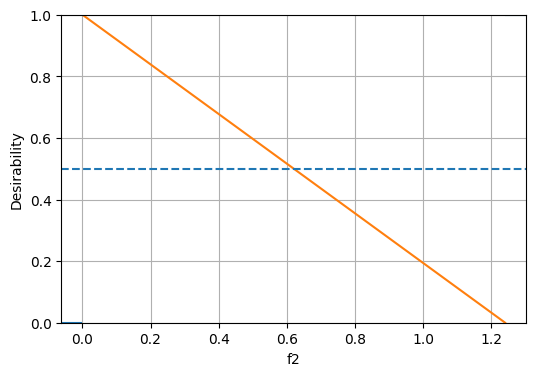

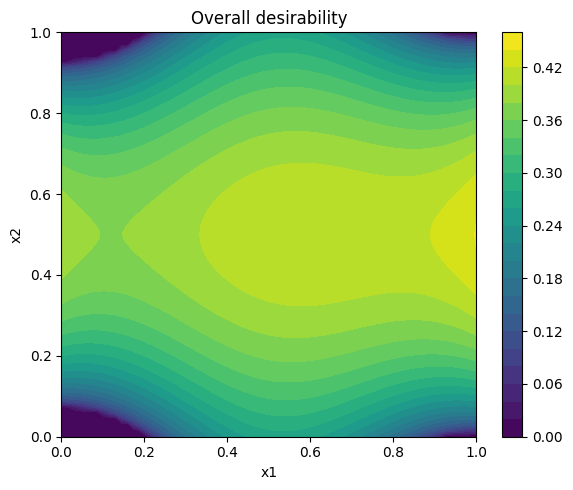

DTLZ2 STEP 2 DONE


In [13]:
# ============================================================
# DTLZ2 — Step 1: Data generation
# ============================================================

import numpy as np

print("DTLZ2: Concave Pareto Front (2 objectives) — TRUE 2D slice sampling")
print("-" * 60)

# -------------------------
# Problem setup
# -------------------------
n_obj = 2
n_var = 11                 # M=2, k=10 -> n = 2 + 10 - 1 = 11

n_nonopt = 200
n_pareto = 300

pair_opt = (0, 1)          # slice variables: (x1, x2)
fixed_value = 0.5          # x3..x11 fixed at 0.5 (=> g=0 when also x2=0.5)

# -------------------------
# 1) Non-optimal samples (TRUE 2D slice: only x1,x2 vary)
# -------------------------
X_nonopt_2d = np.random.rand(n_nonopt, 2)      # x1,x2 in [0,1]

# -------------------------
# 2) TRUE Pareto points on THIS slice
# For DTLZ2 (M=2), PF occurs when g=0 => x2..x11 = 0.5
# On our slice (x1,x2): set x2=0.5 and vary x1 in [0,1]
# -------------------------
x0_pf = np.linspace(0, 1, n_pareto)
X_pareto_2d = np.column_stack([x0_pf, np.full(n_pareto, 0.5)])

# -------------------------
# 3) Combine
# -------------------------
X_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
n_samples = X_2d.shape[0]

# -------------------------
# 4) Embed to full 11D (TRUE slice: x3..x11 fixed to 0.5)
# -------------------------
X_full = np.full((n_samples, n_var), fixed_value, dtype=float)
X_full[:, 0] = X_2d[:, 0]   # x1
X_full[:, 1] = X_2d[:, 1]   # x2

# Evaluate (analytic)
y_samples = dtlz2(X_full, n_obj=n_obj)

print(f"Non-opt samples (TRUE 2D slice): {n_nonopt}")
print(f"Pareto samples (x2=0.5 line, TRUE PF on slice): {n_pareto}")
print(f"Total samples: {n_samples}")
print(f"Objective space shape: {y_samples.shape}")
print(f"f1 range: [{y_samples[:, 0].min():.4f}, {y_samples[:, 0].max():.4f}]")
print(f"f2 range: [{y_samples[:, 1].min():.4f}, {y_samples[:, 1].max():.4f}]")

# PF check: on injected PF points, radius should be ~1 (concave unit quarter circle)
Y_pf = y_samples[n_nonopt:, :]
pf_radius = np.sqrt(Y_pf[:, 0]**2 + Y_pf[:, 1]**2)
print(f"PF check: mean sqrt(f1^2+f2^2) = {pf_radius.mean():.6f} (expected ~1.0)")

# -------------------------
# Pipeline parameters
# -------------------------
func_name = "DTLZ2"
test_func = dtlz2

pairs = [pair_opt]
n_grid = 70
bounds = ((0, 1), (0, 1))    # slice variables x1,x2 are both in [0,1]

target_names = ("f1", "f2")
is_minimization = True
func_kwargs = {"n_obj": n_obj}

# Grid data (analytic evaluation on the grid)
# IMPORTANT: fixed_value applies ONLY to non-plotted variables (x3..x11)
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

# Desirability objects + desirability grid
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))

# ============================================================
# DTLZ2 — Step 2: Visualization
# ============================================================

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(
    y_samples,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=is_minimization,
    var_names=("x1", "x2"),
    target_names=target_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

DTLZ3: PF injected + single-band non-opt (stable radius filtering)
------------------------------------------------------------
PF radius mean: 1.000000 (expected ~1.0)
Non-opt samples: 200
Pareto samples:  600
Total samples:   800
f1 range: [0.0000, 1.8569]
f2 range: [0.0000, 1.8418]
DTLZ3 STEP 1 DONE
grid_data keys: [(0, 1)]


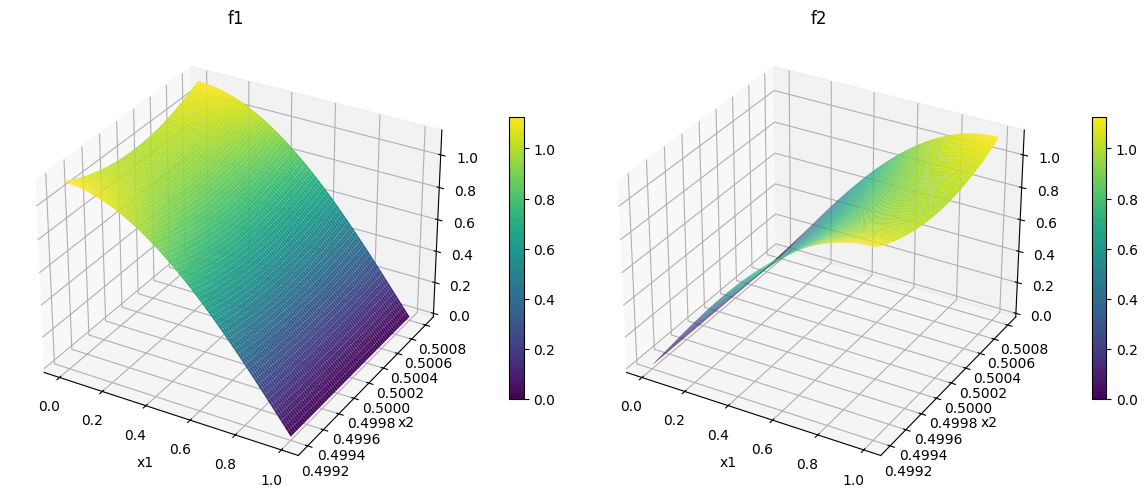

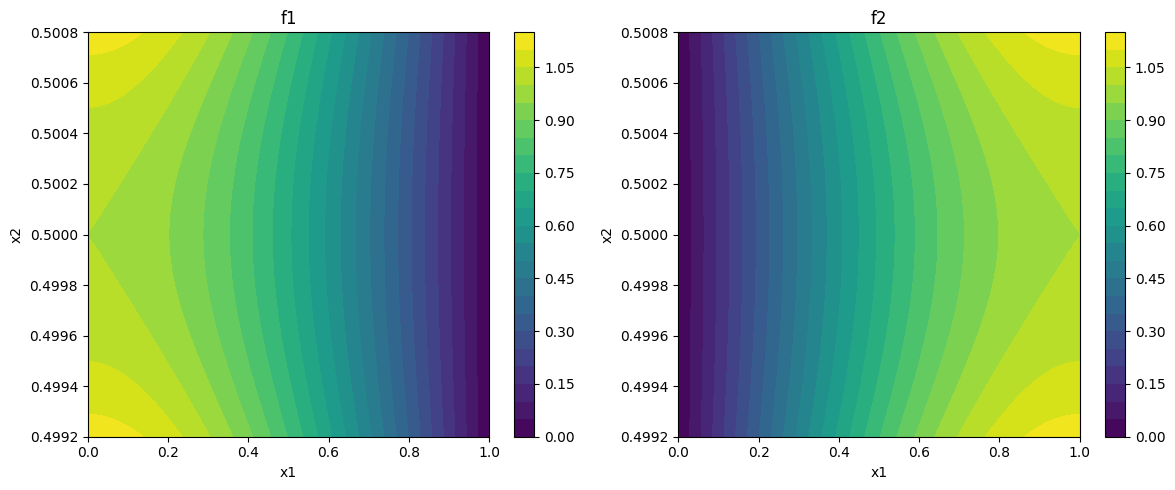

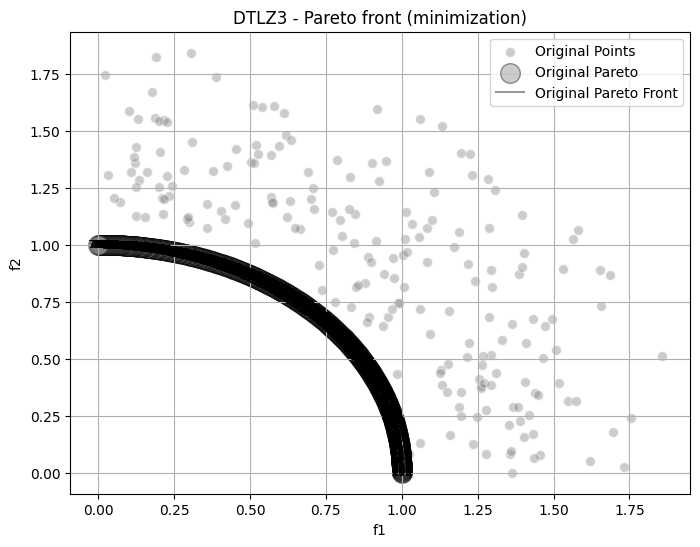

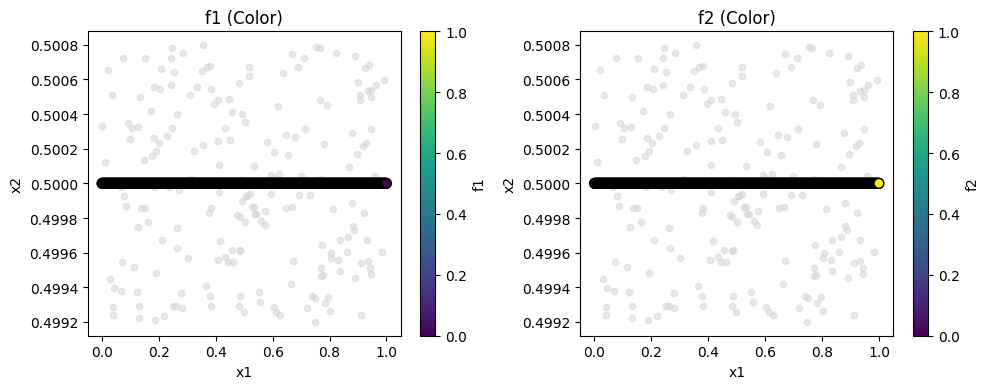

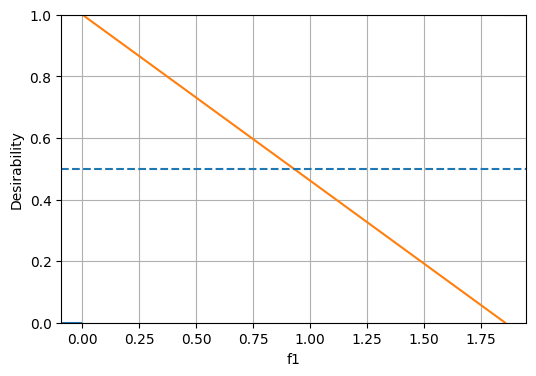

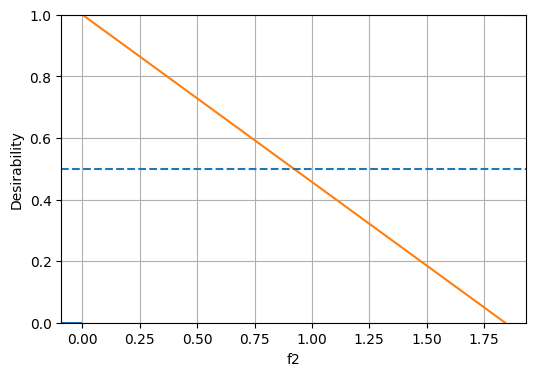

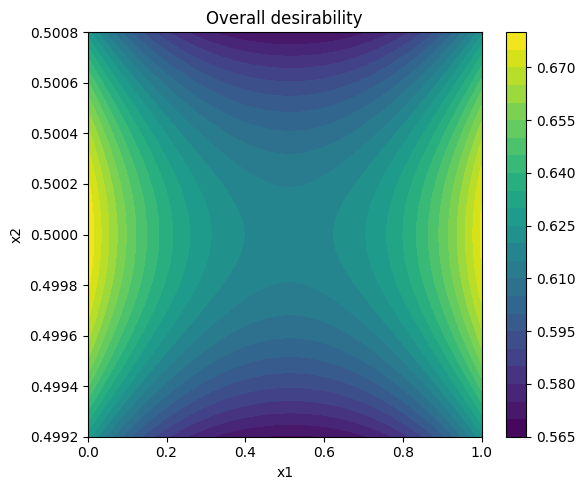

DTLZ3 STEP 2 DONE


In [14]:
# ============================================================
# DTLZ3 — Step 1: Data generation
# ============================================================

import numpy as np

print("DTLZ3: PF injected + single-band non-opt (stable radius filtering)")
print("-" * 60)

# -------------------------
# Problem setup
# -------------------------
n_obj = 2
n_var = 6              # M=2, k=5 -> n=6
n_pareto = 600
n_nonopt = 200

pair_opt = (0, 1)       # visible slice: (x1, x2)
fixed_value = 0.5       # baseline for hidden vars

# -------------------------
# 1) PF injected (true PF)
# PF condition for DTLZ3: g=0 -> x2..x6 = 0.5 (for M=2)
# On our 2D slice: set x2=0.5 and vary x1 in [0,1]
# -------------------------
x0_pf = np.linspace(0, 1, n_pareto)
X_pareto_2d = np.column_stack([x0_pf, np.full(n_pareto, 0.5)])

X_pareto_full = np.full((n_pareto, n_var), fixed_value, dtype=float)
X_pareto_full[:, 0] = x0_pf   # x1 varies
X_pareto_full[:, 1] = 0.5     # x2 fixed on PF

Y_pareto = dtlz3(X_pareto_full, n_obj=n_obj)
r_pf = np.sqrt(Y_pareto[:, 0]**2 + Y_pareto[:, 1]**2)
print(f"PF radius mean: {r_pf.mean():.6f} (expected ~1.0)")

# -------------------------
# 2) Non-opt: one smooth cloud near PF (DTLZ3 is very sensitive)
# Keep x2 and hidden variables VERY close to 0.5, otherwise g explodes.
# We'll accept points slightly outside PF radius, but not too far.
# -------------------------
delta = 0.01            # accept points with radius > 1+delta
r_max = 2.0             # cap radius to keep objective scale reasonable

x1_band = 8e-4          # x2 near 0.5 (visible slice band)
sigma_hidden = 8e-4     # hidden vars near 0.5 (gaussian)

need = n_nonopt
kept_X = []
kept_Y = []

for _ in range(12):     # bounded attempts
    n_cand = 25000

    X = np.full((n_cand, n_var), fixed_value, dtype=float)
    X[:, 0] = np.random.rand(n_cand)  # x1 free in [0,1]

    # visible x2: tiny band around 0.5
    X[:, 1] = 0.5 + np.random.uniform(-x1_band, x1_band, size=n_cand)

    # hidden vars x3..x6: tiny gaussian around 0.5
    X[:, 2:] = 0.5 + np.random.normal(0.0, sigma_hidden, size=(n_cand, n_var - 2))

    # clip to [0,1]
    X[:, 1:] = np.clip(X[:, 1:], 0.0, 1.0)

    Y = dtlz3(X, n_obj=n_obj)
    r = np.sqrt(Y[:, 0]**2 + Y[:, 1]**2)

    mask = (r > 1.0 + delta) & (r < r_max)
    if np.any(mask):
        kept_X.append(X[mask])
        kept_Y.append(Y[mask])

    if sum(a.shape[0] for a in kept_X) >= need:
        break

if len(kept_X) == 0:
    raise RuntimeError(
        "No non-optimal points accepted. For DTLZ3, perturbations must be very small.\n"
        "Try: reduce x1_band/sigma_hidden (e.g., 5e-4), or increase r_max (e.g., 3.0), "
        "or reduce delta (e.g., 0.005)."
    )

X_nonopt_full = np.vstack(kept_X)[:need]
Y_nonopt = np.vstack(kept_Y)[:need]
X_nonopt_2d = X_nonopt_full[:, :2]

# -------------------------
# 3) Combine
# -------------------------
X_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
y_samples = np.vstack([Y_nonopt, Y_pareto])

print(f"Non-opt samples: {X_nonopt_full.shape[0]}")
print(f"Pareto samples:  {X_pareto_full.shape[0]}")
print(f"Total samples:   {y_samples.shape[0]}")
print(f"f1 range: [{y_samples[:, 0].min():.4f}, {y_samples[:, 0].max():.4f}]")
print(f"f2 range: [{y_samples[:, 1].min():.4f}, {y_samples[:, 1].max():.4f}]")

# -------------------------
# Pipeline parameters
# -------------------------
func_name = "DTLZ3"
test_func = dtlz3

pairs = [pair_opt]
n_grid = 70

# IMPORTANT: keep grid slice near x2=0.5 to avoid large g explosions
bounds = ((0, 1), (0.5 - x1_band, 0.5 + x1_band))

target_names = ("f1", "f2")
is_minimization = True
func_kwargs = {"n_obj": n_obj}

# Grid data (analytic evaluation on the grid)
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,    # x3..x6 baseline at 0.5
    func_kwargs=func_kwargs
)

# Desirability objects + desirability grid
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    is_minimization=is_minimization
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))


# ============================================================
# DTLZ3 — Step 2: Visualization
# ============================================================

var_names = ("x1", "x2")

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(
    y_samples,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=is_minimization,
    var_names=var_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

DTLZ4: Concave with Biased Density (TRUE 2D slice sampling)
------------------------------------------------------------
Original samples: 900
Filtered samples: 900
  - Pareto samples (TRUE PF on slice): 600  (x2=0.5, x3..x11=0.5)
  - Non-opt samples (TRUE 2D slice):   300  (x2 in [0,1], x3..x11=0.5)
Objective space shape: (900, 2)
f1 range: [0.0000, 1.2486]
f2 range: [0.0000, 1.1595]

✓ PF check: mean sqrt(f1^2+f2^2) = 1.000000 (expected ~1.0)
  PF check: radius range = [1.000000, 1.000000]
  Bias diagnostic: 78% have x1^alpha < 0.1 (alpha=100)

DTLZ4 (alpha=100) STEP 1 DONE
grid_data keys: [(0, 1)]


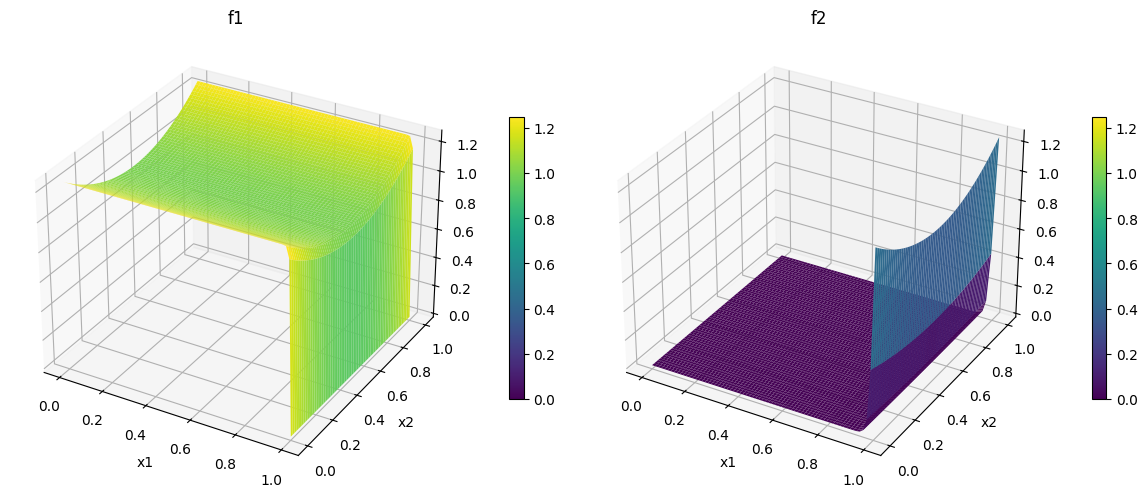

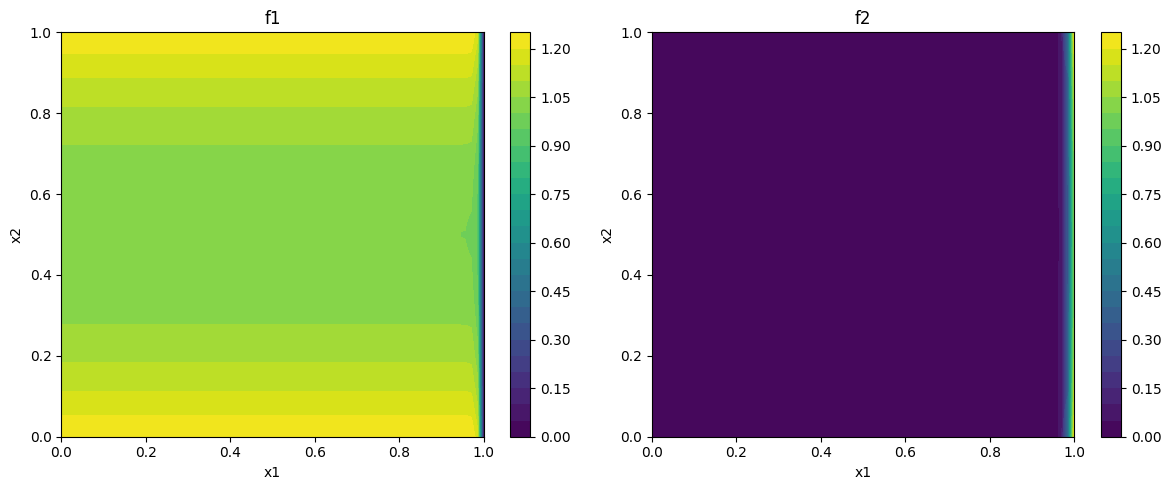

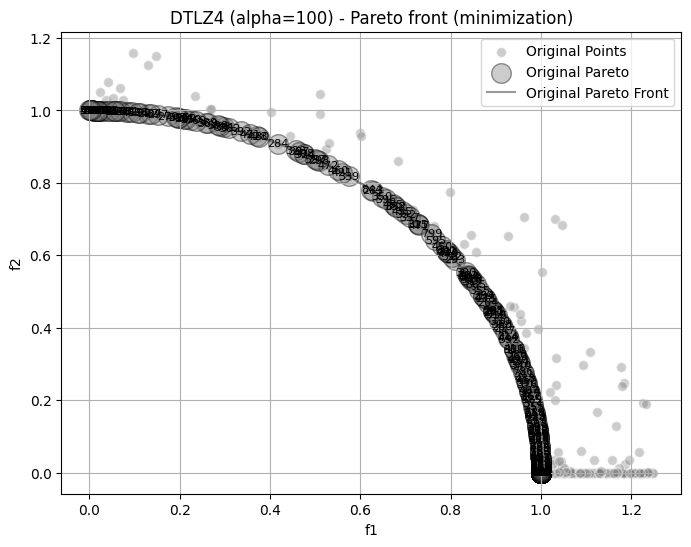

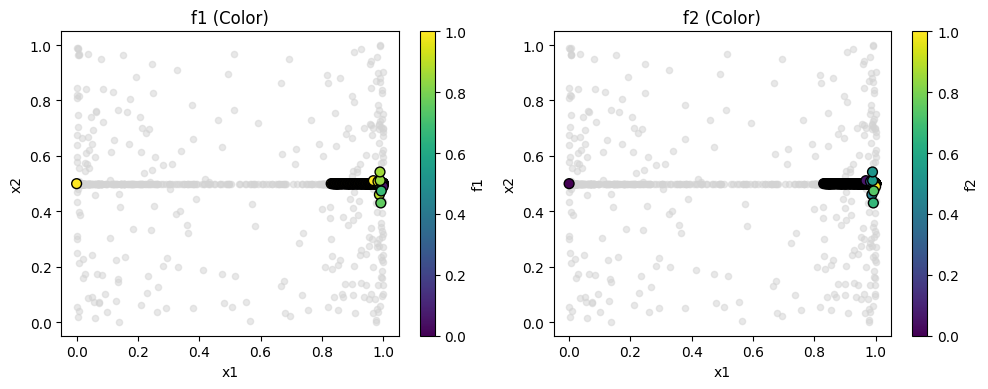

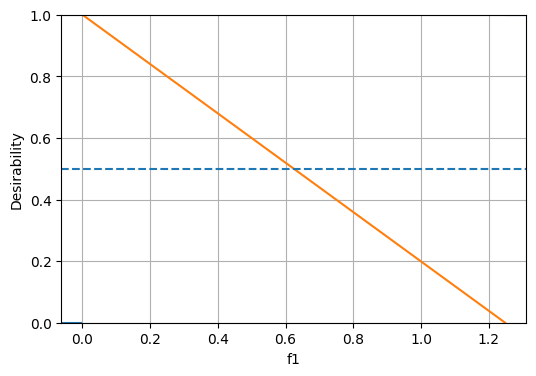

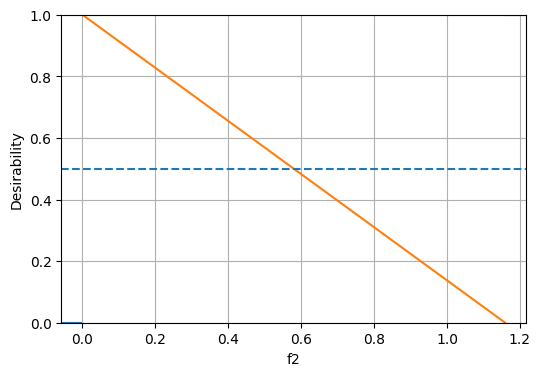

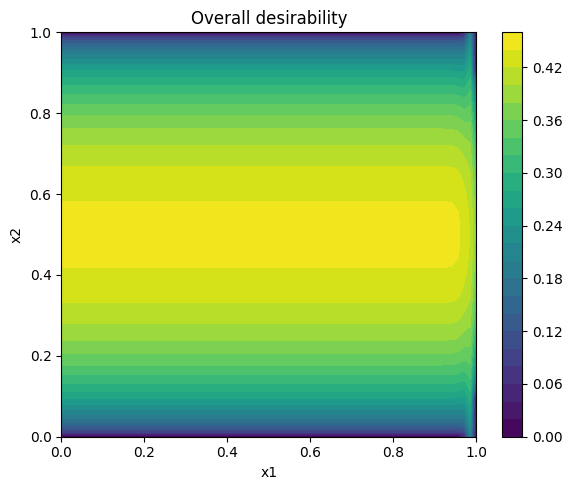

DTLZ4 (alpha=100) STEP 2 DONE


In [15]:
# ============================================================
# DTLZ4 — Step 1: Data generation
# 2D slice on (x1, x2); x3..x11 fixed at 0.5
# ============================================================

import numpy as np

print("DTLZ4: Concave with Biased Density (TRUE 2D slice sampling)")
print("-" * 60)

# -------------------------
# Config
# -------------------------
func_name = "DTLZ4 (alpha=100)"
test_func = dtlz4

n_obj = 2
n_var = n_obj + 10 - 1          # = 11 (M=2, k=10 -> n=11)
alpha = 100

n_pareto = 500
n_nonopt = 300

fixed_value = 0.5               # x3..x11 fixed
pairs = [(0, 1)]
n_grid = 70
bounds = ((0, 1), (0, 1))       # x1, x2 in [0,1] for this slice

target_names = ("f1", "f2")
is_minimization = True
func_kwargs = {"n_obj": n_obj, "alpha": alpha}

# -------------------------
# 1) Pareto-optimal points (TRUE PF on the slice)
# PF condition for DTLZ4/DTLZ2 family: g=0 -> x2..x11 = 0.5
# On (x1,x2) slice: x2=0.5 and x3..x11=0.5, only x1 varies
# -------------------------

# Strategic x1 sampling to emphasize DTLZ4 bias (alpha=100)
x0_low = np.random.beta(0.5, 2, size=n_pareto // 2)
x0_high = 1 - np.random.beta(0.5, 8, size=n_pareto // 2)
x0_uniform = np.linspace(0.8, 1.0, 100)

x0_pf = np.concatenate([x0_low, x0_high, x0_uniform])
n_pareto = len(x0_pf)

X_pareto_full = np.full((n_pareto, n_var), fixed_value)
X_pareto_full[:, 0] = x0_pf
X_pareto_full[:, 1] = 0.5

y_pareto = test_func(X_pareto_full, **func_kwargs)

# -------------------------
# 2) Non-optimal points (TRUE 2D slice cloud)
# Only x1 and x2 vary; x3..x11 fixed at 0.5
# -------------------------
X_nonopt_full = np.full((n_nonopt, n_var), fixed_value)

x0_nonopt_low = np.random.beta(0.5, 2, size=n_nonopt // 2)
x0_nonopt_high = 1 - np.random.beta(0.5, 8, size=n_nonopt // 2)
X_nonopt_full[:, 0] = np.concatenate([x0_nonopt_low, x0_nonopt_high])

# TRUE 2D slice: vary ONLY x2 in [0,1]
X_nonopt_full[:, 1] = np.random.rand(n_nonopt)

y_nonopt = test_func(X_nonopt_full, **func_kwargs)

# -------------------------
# 3) Combine
# -------------------------
X_full_all = np.vstack([X_pareto_full, X_nonopt_full])
y_dtlz4_all = np.vstack([y_pareto, y_nonopt])

# For input-space plot (x1 vs x2)
X_vis_dtlz4 = X_full_all[:, :2]

# -------------------------
# 4) Filter outliers (radius > 2.5); PF points are always kept
# -------------------------
radius_all = np.sqrt(y_dtlz4_all[:, 0]**2 + y_dtlz4_all[:, 1]**2)
keep_mask = radius_all < 2.5
# Always keep all PF points
keep_mask[:n_pareto] = True

X_full_keep = X_full_all[keep_mask]
y_dtlz4 = y_dtlz4_all[keep_mask]
X_vis_dtlz4 = X_full_keep[:, :2]

print(f"Original samples: {len(X_full_all)}")
print(f"Filtered samples: {len(X_full_keep)}")
print(f"  - Pareto samples (TRUE PF on slice): {n_pareto}  (x2=0.5, x3..x11=0.5)")
print(f"  - Non-opt samples (TRUE 2D slice):   {len(X_full_keep) - n_pareto}  (x2 in [0,1], x3..x11=0.5)")
print(f"Objective space shape: {y_dtlz4.shape}")
print(f"f1 range: [{y_dtlz4[:, 0].min():.4f}, {y_dtlz4[:, 0].max():.4f}]")
print(f"f2 range: [{y_dtlz4[:, 1].min():.4f}, {y_dtlz4[:, 1].max():.4f}]")

# PF check: for PF points (first n_pareto after filtering), radius should be ~1 (g=0)
Y_pf = y_dtlz4[:n_pareto, :]
pf_radius = np.sqrt(Y_pf[:, 0]**2 + Y_pf[:, 1]**2)
print(f"\n✓ PF check: mean sqrt(f1^2+f2^2) = {pf_radius.mean():.6f} (expected ~1.0)")
print(f"  PF check: radius range = [{pf_radius.min():.6f}, {pf_radius.max():.6f}]")

# Bias effect diagnostic (DTLZ4 characteristic)
x0_alpha = (X_full_keep[:n_pareto, 0] ** alpha)
print(f"  Bias diagnostic: {100*np.sum(x0_alpha < 0.1)/n_pareto:.0f}% have x1^alpha < 0.1 (alpha={alpha})")

# -------------------------
# Grid data and desirability
# Note: non-plotted variables (x3..x11) are fixed at 0.5 in the grid as well.
# -------------------------
grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_dtlz4, is_minimization=is_minimization
)

Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"\n{func_name} STEP 1 DONE")
print("grid_data keys:", list(grid_data.keys()))


# ============================================================
# DTLZ4 — Step 2: Visualization
# ============================================================

var_names = ("x1", "x2")

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(
    y_dtlz4,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_vis_dtlz4,
    y_dtlz4,
    is_minimization=is_minimization,
    var_names=var_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")

DTLZ5: Degenerate Pareto Front (TRUE 2D slice sampling + visible non-opt)
------------------------------------------------------------
Non-opt samples: 250 | PF samples: 250 | Total: 500
DTLZ5 STEP 1 DONE


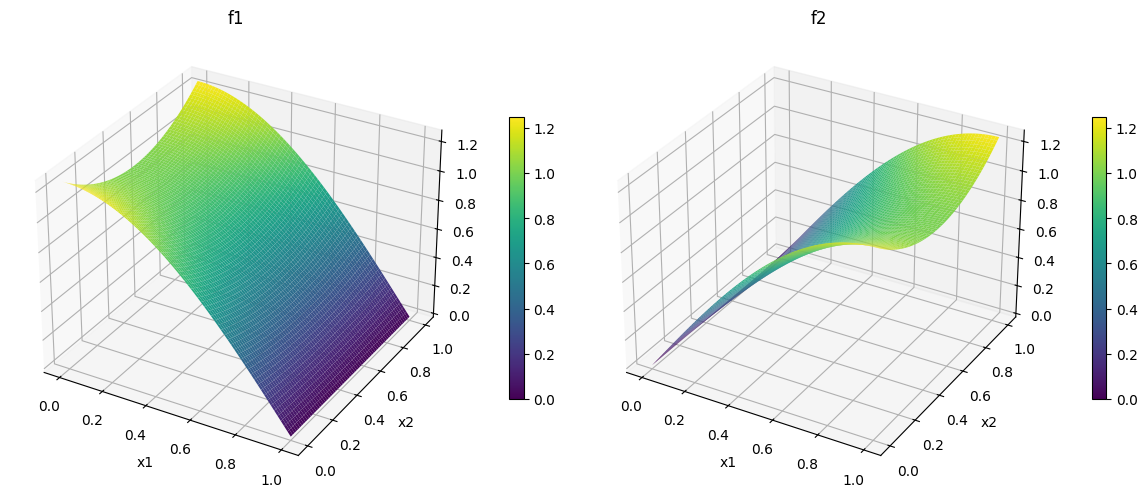

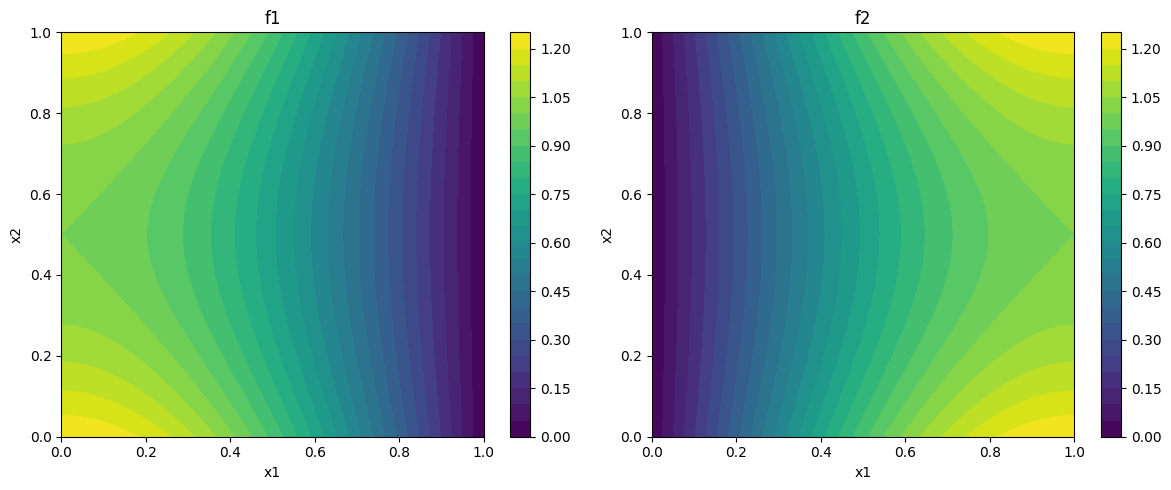

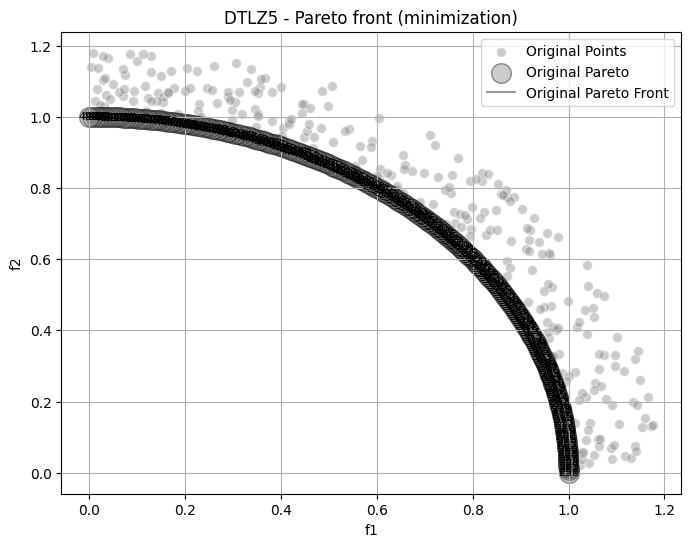

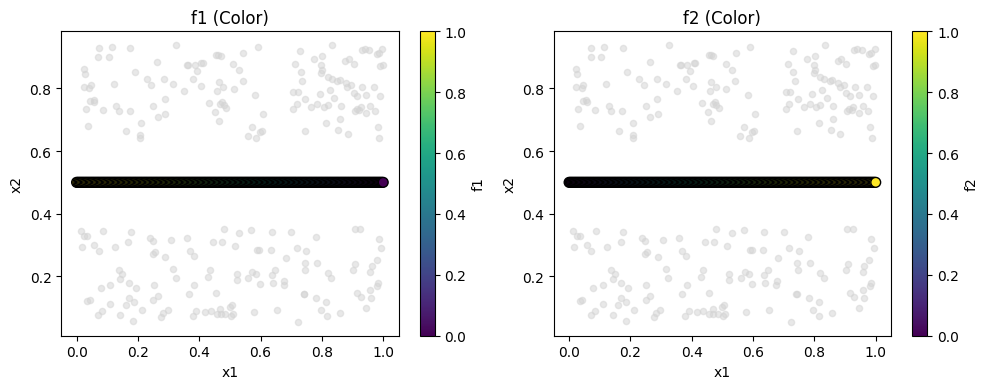

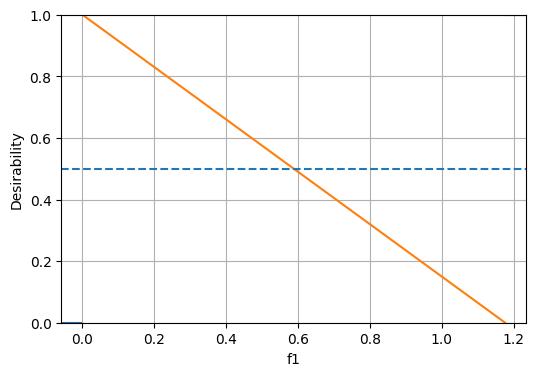

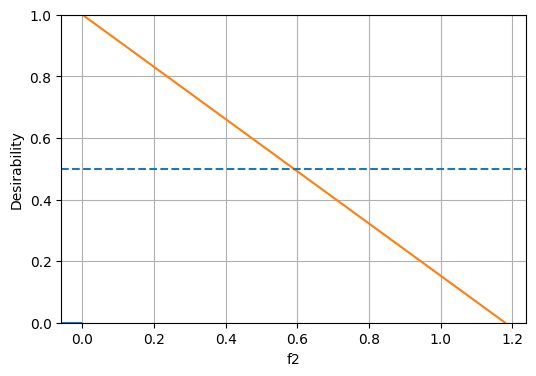

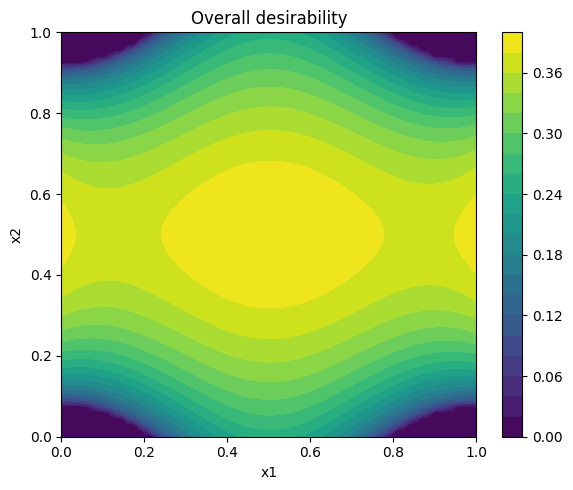

In [16]:
# ============================================================
# DTLZ5 — Step 1: Data generation
# 2D slice on (x1, x2); x3..x11 fixed at 0.5
# ============================================================

import numpy as np

print("DTLZ5: Degenerate Pareto Front (TRUE 2D slice sampling + visible non-opt)")
print("-" * 60)

n_obj = 2
n_var = n_obj + 10 - 1   # 11 variables (M=2, k=10)

n_pareto = 250
n_nonopt = 250

# -------------------------
# 1) Pareto points on slice (g=0 => x2..x11=0.5)
# On this slice we keep x2=0.5 and vary x1
# -------------------------
x0_pf = np.linspace(0, 1, n_pareto)

X_pareto_full = np.zeros((n_pareto, n_var))
X_pareto_full[:, 0] = x0_pf
X_pareto_full[:, 1:] = 0.5

y_pareto = dtlz5(X_pareto_full, n_obj=n_obj)

# -------------------------
# 2) Non-opt points on SAME slice (TRUE 2D slice): vary (x1,x2), keep x3..=0.5
# Filter to keep points slightly outside PF to be visible
# -------------------------
need = n_nonopt
kept_X, kept_Y = [], []

delta = 0.02
r_max = 1.20

for _ in range(12):
    n_cand = 20000
    Xc = np.zeros((n_cand, n_var))
    Xc[:, 0] = np.random.rand(n_cand)   # x1
    Xc[:, 1] = np.random.rand(n_cand)   # x2  (TRUE 2D slice)
    Xc[:, 2:] = 0.5                     # x3.. fixed

    Yc = dtlz5(Xc, n_obj=n_obj)
    rc = np.sqrt(Yc[:, 0]**2 + Yc[:, 1]**2)

    mask = (rc > 1.0 + delta) & (rc < r_max)
    if np.any(mask):
        kept_X.append(Xc[mask])
        kept_Y.append(Yc[mask])

    if sum(a.shape[0] for a in kept_X) >= need:
        break

if len(kept_X) == 0:
    raise RuntimeError("No non-opt points accepted. Try decrease delta or increase r_max.")

X_nonopt_full = np.vstack(kept_X)[:need]
y_nonopt = np.vstack(kept_Y)[:need]

# -------------------------
# 3) Combine (non-opt first, then PF)
# -------------------------
X_full = np.vstack([X_nonopt_full, X_pareto_full])
X_base_2d = X_full[:, :2]
y_dtlz5 = np.vstack([y_nonopt, y_pareto])

# -------------------------
# 4) Grid + desirability (must match slice)
# -------------------------
func_name = "DTLZ5"
test_func = dtlz5
pairs = [(0, 1)]
n_grid = 70
fixed_value = 0.5
bounds = ((0, 1), (0, 1))
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = {"n_obj": 2}

grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

d_funcs, D_overall = make_desirability_objects_from_samples(y_samples=y_dtlz5, is_minimization=is_minimization)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"Non-opt samples: {n_nonopt} | PF samples: {n_pareto} | Total: {y_dtlz5.shape[0]}")
print(f"{func_name} STEP 1 DONE")


# ============================================================
# DTLZ5 — Step 2: Visualization
# ============================================================

var_names = ("x1", "x2")

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(y_dtlz5, func_name=func_name, target_names=target_names, is_minimization=is_minimization)
plot_pareto_x_in_input_space(X_base_2d, y_dtlz5, is_minimization=is_minimization, var_names=var_names)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

DTLZ6: TRUE 2D slice (x0,x1), x2..x10 fixed = 0.0
------------------------------------------------------------
Non-opt: 250 | PF: 200 | Total: 450
DTLZ6 STEP 1 DONE


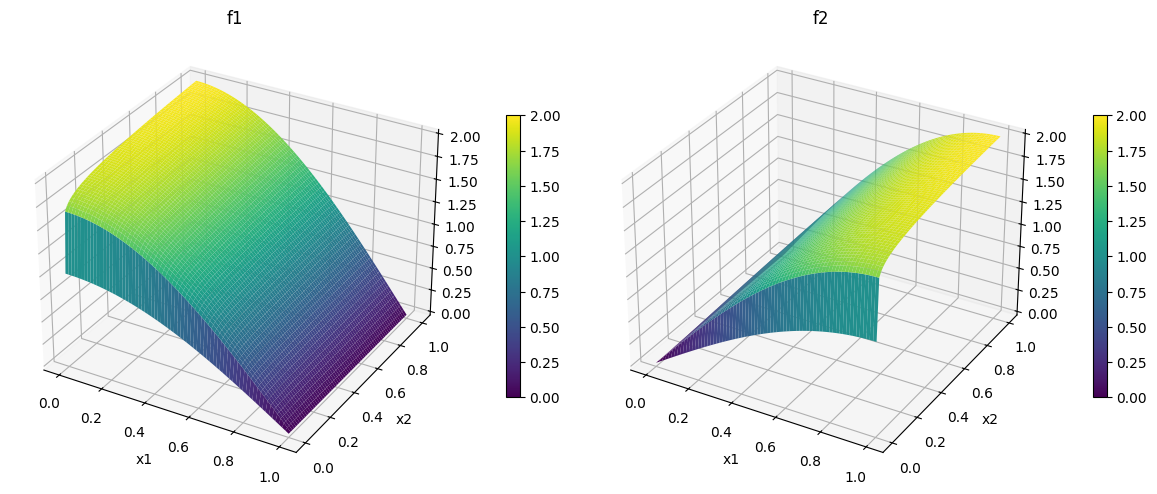

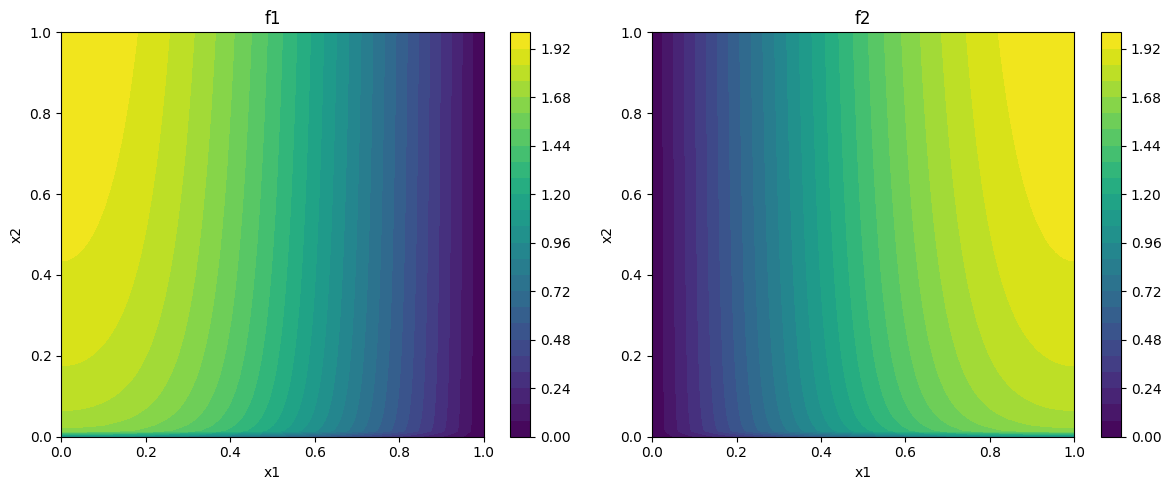

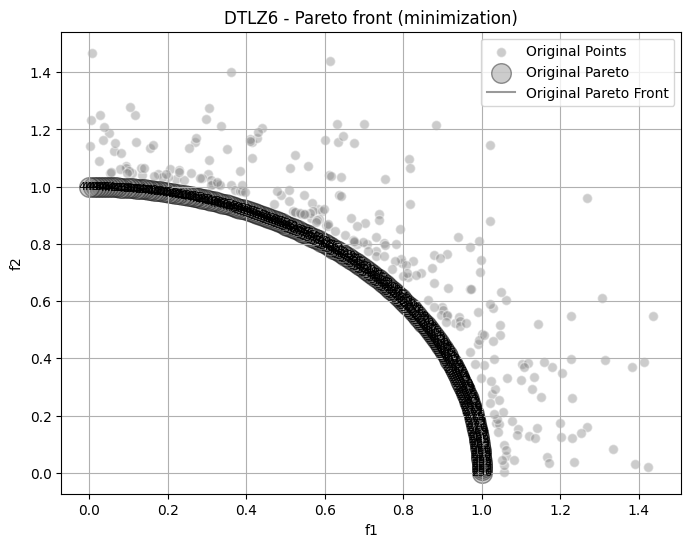

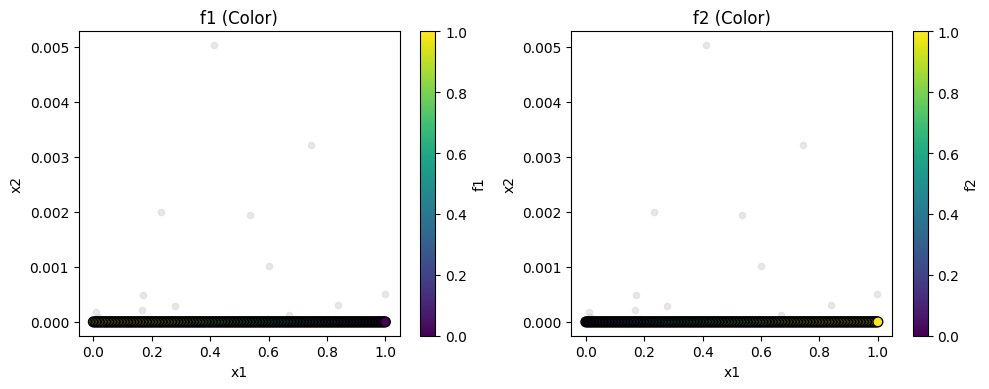

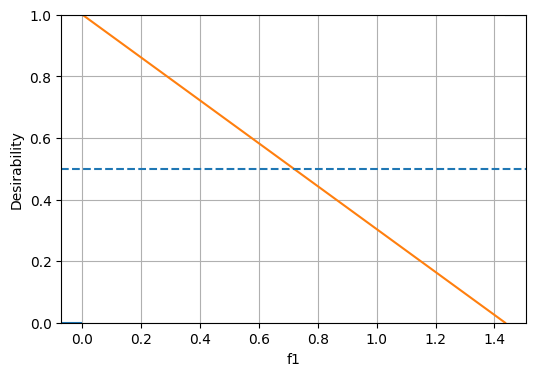

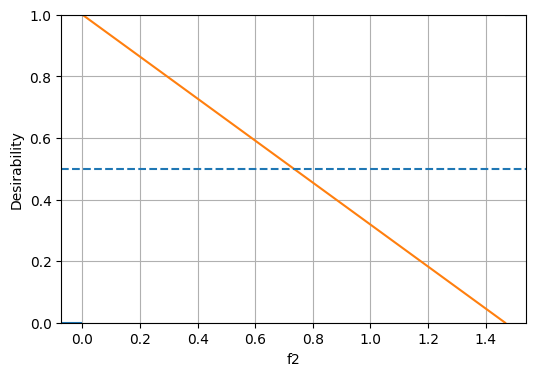

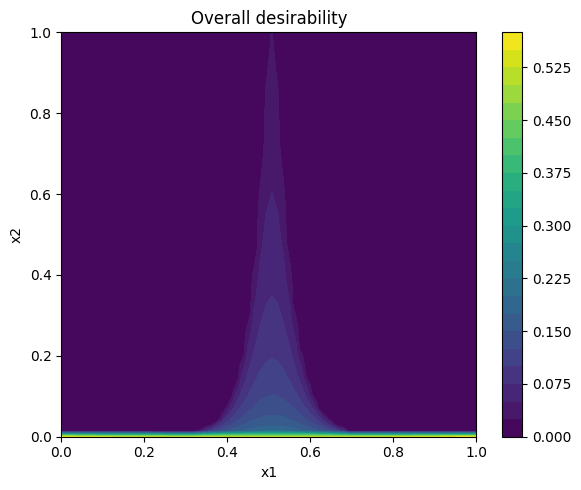

In [17]:
# ============================================================
# DTLZ6 — Step 1: Data generation
# 2D slice on (x1, x2); x3..x11 fixed at 0.0
# ============================================================

import numpy as np

print("DTLZ6: TRUE 2D slice (x0,x1), x2..x10 fixed = 0.0")
print("-" * 60)

n_obj = 2
k = 10
n_var = n_obj + k - 1   # 11 variables

n_pareto = 200
n_nonopt = 250

fixed_value = 0.0

# 1) PF points on this slice: g=0 => x1..x10=0, so x1=0 and tail zeros
x0_pf = np.linspace(0, 1, n_pareto)
X_pareto_full = np.zeros((n_pareto, n_var))
X_pareto_full[:, 0] = x0_pf
X_pareto_2d = np.column_stack([x0_pf, np.zeros(n_pareto)])

y_pareto = dtlz6(X_pareto_full, n_obj=n_obj)

# 2) Non-opt points on same slice: choose g in [0.05,0.60] => x1 = g^10
g_min, g_max = 0.05, 0.60
g = g_min + (g_max - g_min) * np.random.beta(a=0.5, b=2.0, size=n_nonopt)

X_nonopt_full = np.zeros((n_nonopt, n_var))
X_nonopt_full[:, 0] = np.random.rand(n_nonopt)
X_nonopt_full[:, 1] = g**10
X_nonopt_2d = X_nonopt_full[:, :2]

y_nonopt = dtlz6(X_nonopt_full, n_obj=n_obj)

# 3) Combine (non-opt first)
X_full = np.vstack([X_nonopt_full, X_pareto_full])
X_base_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
y_dtlz6 = np.vstack([y_nonopt, y_pareto])

# 4) Grid data and desirability
func_name = "DTLZ6"
test_func = dtlz6
pairs = [(0, 1)]
n_grid = 70
bounds = ((0, 1), (0, 1))
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = {"n_obj": 2}

grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

d_funcs, D_overall = make_desirability_objects_from_samples(y_samples=y_dtlz6, is_minimization=is_minimization)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"Non-opt: {n_nonopt} | PF: {n_pareto} | Total: {y_dtlz6.shape[0]}")
print(f"{func_name} STEP 1 DONE")


# ============================================================
# DTLZ6 — Step 2: Visualization
# ============================================================

var_names = ("x1", "x2")

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

plot_pareto_from_y(y_dtlz6, func_name=func_name, target_names=target_names, is_minimization=is_minimization)
plot_pareto_x_in_input_space(X_base_2d, y_dtlz6, is_minimization=is_minimization, var_names=var_names)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

DTLZ7: TRUE 2D slice (disconnected PF regions)
------------------------------------------------------------
PF points kept: 289 | Non-opt: 250 | Total: 539
DTLZ7 STEP 1 DONE


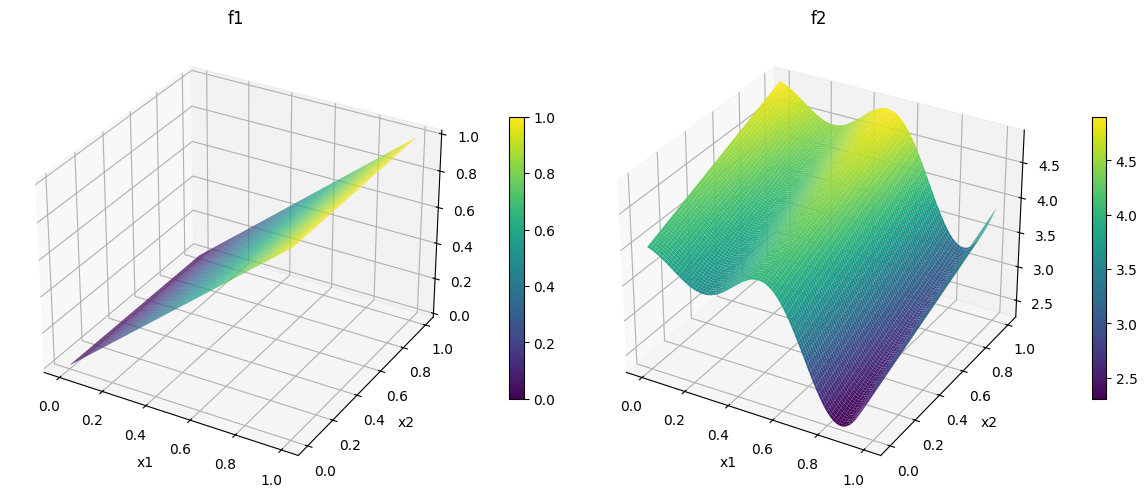

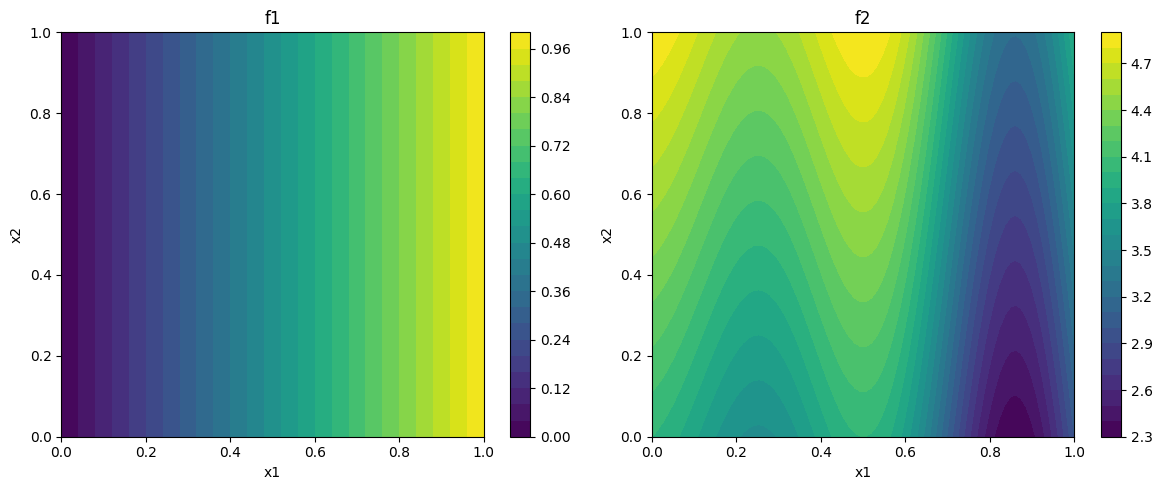

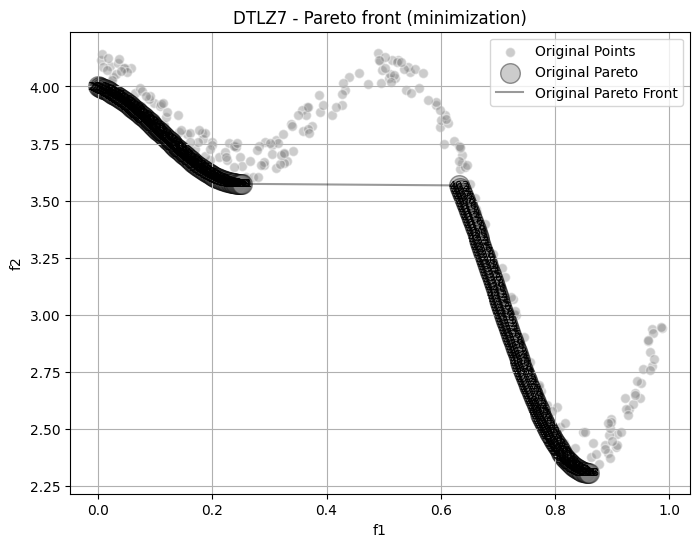

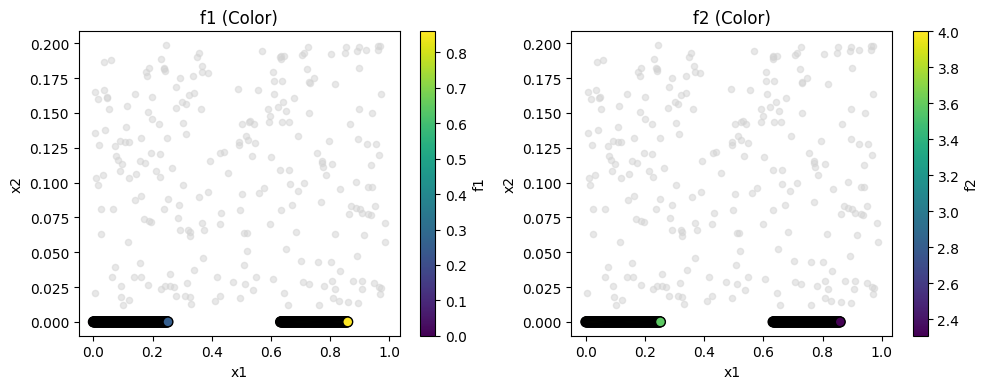

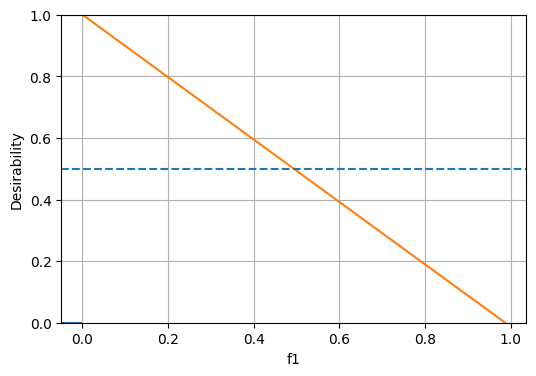

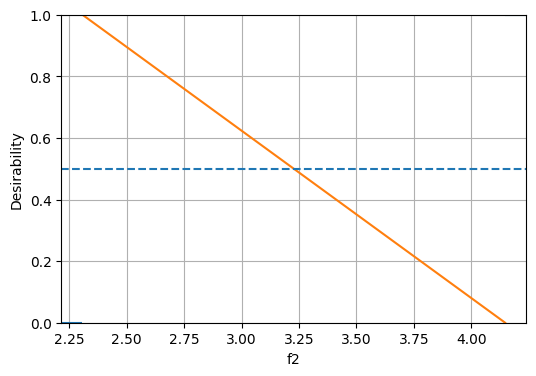

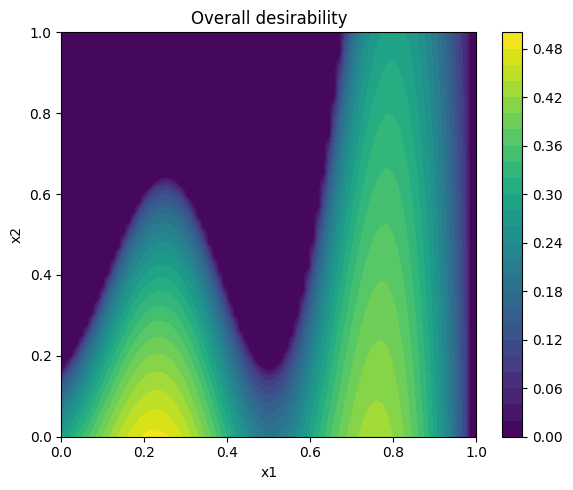

DTLZ7 STEP 2 DONE


In [18]:
# ============================================================
# DTLZ7 — Step 1: Data generation
# 2D slice on (x1, x2); x3..x21 fixed at 0.0
# Non-dominated filtering is applied to extract the disconnected true Pareto front.
# ============================================================

import numpy as np

print("DTLZ7: TRUE 2D slice (disconnected PF regions)")
print("-" * 60)

np.random.seed(42)

n_obj = 2
k = 20
n_var = n_obj + k - 1   # 21 variables

n_pareto = 600
n_nonopt = 250
fixed_value = 0.0

def nondominated_mask(F):
    F = np.asarray(F)
    n = F.shape[0]
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        if not keep[i]:
            continue
        dom_i = np.all(F <= F[i], axis=1) & np.any(F < F[i], axis=1)
        if np.any(dom_i):
            keep[i] = False
            continue
        dominated_by_i = np.all(F[i] <= F, axis=1) & np.any(F[i] < F, axis=1)
        keep[dominated_by_i] = False
        keep[i] = True
    return keep

# 1) PF candidates on slice: x1..x20=0, only x0 varies
x0_pf = np.linspace(0, 1, n_pareto)
X_pf_full = np.zeros((n_pareto, n_var))
X_pf_full[:, 0] = x0_pf

y_pf_all = dtlz7(X_pf_full, n_obj=n_obj)
mask_pf = nondominated_mask(y_pf_all)

X_pareto_full = X_pf_full[mask_pf]
y_pareto = y_pf_all[mask_pf]
X_pareto_2d = np.column_stack([X_pareto_full[:, 0], np.zeros(X_pareto_full.shape[0])])

# 2) Non-opt points on SAME slice: x1 band > 0, tail zeros
X_nonopt_full = np.zeros((n_nonopt, n_var))
X_nonopt_full[:, 0] = np.random.rand(n_nonopt)
X_nonopt_full[:, 1] = np.random.uniform(0.01, 0.20, n_nonopt)
X_nonopt_2d = X_nonopt_full[:, :2]
y_nonopt = dtlz7(X_nonopt_full, n_obj=n_obj)

# 3) Combine (non-opt first)
X_full = np.vstack([X_nonopt_full, X_pareto_full])
X_base_2d = np.vstack([X_nonopt_2d, X_pareto_2d])
y_dtlz7 = np.vstack([y_nonopt, y_pareto])

# 4) Grid + desirability (same slice)
func_name = "DTLZ7"
test_func = dtlz7
pairs = [(0, 1)]
n_grid = 80
bounds = ((0, 1), (0, 1))
target_names = ("f1", "f2")
is_minimization = True
func_kwargs = {"n_obj": 2}

grid_data = make_grid_dataset(
    test_func=test_func,
    n_var=n_var,
    pairs=pairs,
    bounds=bounds,
    n_grid=n_grid,
    fixed_value=fixed_value,
    func_kwargs=func_kwargs
)

d_funcs, D_overall = make_desirability_objects_from_samples(y_samples=y_dtlz7, is_minimization=is_minimization)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)

print(f"PF points kept: {y_pareto.shape[0]} | Non-opt: {n_nonopt} | Total: {y_dtlz7.shape[0]}")
print(f"{func_name} STEP 1 DONE")


# ============================================================
# DTLZ7 — Step 2: Visualization
# ============================================================

var_names = ("x1", "x2")

plot_surface_from_grid(grid_data, target_names=target_names)
plot_contour_from_grid(grid_data, target_names=target_names)

# Scatter-only Pareto plot: DTLZ7 has a disconnected Pareto front
plot_pareto_from_y(
    y_dtlz7,
    func_name=func_name,
    target_names=target_names,
    is_minimization=is_minimization
)

plot_pareto_x_in_input_space(
    X_base_2d,
    y_dtlz7,
    is_minimization=is_minimization,
    var_names=var_names
)

plot_individual_desirability(d_funcs, target_names=target_names)
plot_overall_desirability_from_grid(grid_data, Dmaps)

print(f"{func_name} STEP 2 DONE")